In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re
import ns
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy
from astropy import units

import ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture as tc
import conversions
import dynamics as dyn
import scripts3
import scripts2
import scripts1
import scripts


sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

%matplotlib inline

matplotlib.rcParams.update({'font.size': 24})
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

2.1.2


In [2]:
##Observed surface brightness, velocity dispersion and number dnesity profiles


###########################################################
cluster = 'ngc104'

##Surface brightness
ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == cluster:
                arcsec_t.append(np.float(linet[2]))
                SB_t.append(np.float(linet[3]))
                flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()
        
        
##Trager data with uncertainties
from astropy.table import Table
data_t = Table.read('makeSBP/sbp_trager1995/trager1995_ngc104.fits')
rarcsec_trager = data_t['r[ARCSEC]']
sbp_trager = data_t['s[MAG/ARCSEC2]']
sbperr_trager = data_t['e_s[MAG/ARCSEC2]']
        

        
############################################################
##Velocity dispersion
distance = 4.52 ##kpc
def err_sigma(f, a, b, sigma_a, sigma_b, err_a, err_b):   ##f = sqrt(a*A^2+b*B^2)
    return np.sqrt((sigma_a/f)**2*a**2*err_a**2 + (sigma_b/f)**2*b**2*err_b**2)

def err_ratio(f, sigma_a, sigma_b, err_a, err_b):   ##f = A/B
    return np.abs(f)*np.sqrt((err_a/sigma_a)**2 + (err_b/sigma_b)**2)

#######################Proper motions#######################
##From Watkins_2015
df_watkins = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/watkins2015_pm.txt', dtype = str)
gc_name_wk = df_watkins[:,0]
r_wk = df_watkins[:,3][gc_name_wk == 'NGC0104'].astype(np.float)  ##in arcsec
r_wk_err = df_watkins[:,4][gc_name_wk == 'NGC0104'].astype(np.float)
sigma_wk = df_watkins[:,5][gc_name_wk == 'NGC0104'].astype(np.float)  ##in mas/yr
sigma_wk_err = df_watkins[:,6][gc_name_wk == 'NGC0104'].astype(np.float)
tr_ratio_wk = df_watkins[:,7][gc_name_wk == 'NGC0104'].astype(np.float)
tr_ratio_err_wk = df_watkins[:,8][gc_name_wk == 'NGC0104'].astype(np.float)

##From Heyl_2017
df_heyl = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/heyl2017_pm.xlsx',
                        names = ['r_proj', 'sigmar_u', 'sigmar_d', 'sigmat_u', 'sigmat_d'])
r_hy = df_heyl['r_proj']*60.  ##in arcsec
sigmar_hy_u = df_heyl['sigmar_u']; sigmar_hy_d = df_heyl['sigmar_d']  ##in mas/yr
sigmat_hy_u = df_heyl['sigmat_u']; sigmat_hy_d = df_heyl['sigmat_d']  ##in mas/yr
sigmar_hy = (sigmar_hy_u+sigmar_hy_d)/2.; sigmar_hy_err = [sigmar_hy_u-sigmar_hy, sigmar_hy-sigmar_hy_d]
sigmat_hy = (sigmat_hy_u+sigmat_hy_d)/2.; sigmat_hy_err = [sigmat_hy_u-sigmat_hy, sigmat_hy-sigmat_hy_d]


sigma_hy = np.sqrt(sigmar_hy**2+sigmat_hy**2)/np.sqrt(2)
sigma_hy_err = [[],[]]
sigma_hy_err[0] = err_sigma(sigma_hy, 0.5, 0.5, sigmar_hy, sigmat_hy, sigmar_hy_err[0], sigmat_hy_err[0])
sigma_hy_err[1] = err_sigma(sigma_hy, 0.5, 0.5, sigmar_hy, sigmat_hy, sigmar_hy_err[1], sigmat_hy_err[1])
tr_ratio_hy = np.array(sigmat_hy)/np.array(sigmar_hy)
tr_ratio_hy_err = [[],[]]
tr_ratio_hy_err[0] = err_ratio(tr_ratio_hy, sigmat_hy, sigmar_hy, sigmat_hy_err[0], sigmar_hy_err[0])
tr_ratio_hy_err[1] = err_ratio(tr_ratio_hy, sigmat_hy, sigmar_hy, sigmat_hy_err[1], sigmar_hy_err[1])


##From Gaia EDR3
df_bg = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Baumgardt_vel_dispersion_profile_47Tuc.xlsx',
                      names = ['name1', 'name2', 'r_proj', 'sigma', 'del_sigma_up', 'del_sigma_low', 'type'])
type_bg = df_bg['type']
r_bg = df_bg['r_proj'][type_bg == 'GEDR3']  ##in arcsec
sigma_bg = df_bg['sigma'][type_bg == 'GEDR3'] ##in km/s
del_sigmau_bg = df_bg['del_sigma_up'][type_bg == 'GEDR3']
del_sigmad_bg = df_bg['del_sigma_low'][type_bg == 'GEDR3']

df_vb = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/pm_tr_ratio_vasiliev_baumgardt2021.xlsx',
                      names = ['r_arcmin', 'tr_ratio1_up', 'tr_ratio1_down', 'tr_ratio1', 'tr_ratio', 'err_up', 'err_down'])
r_vb = df_vb['r_arcmin']*60.
tr_ratio_vb = df_vb['tr_ratio']
tr_ratio_vb_err = [df_vb['err_up'], df_vb['err_down']]


##Conerting units
sigma_wk_kms = uc.pm2vel(distance, sigma_wk)
print(sigma_wk_kms)
sigma_wk_err_kms = uc.pm2vel(distance, sigma_wk_err)

sigmar_hy_kms = uc.pm2vel(distance, sigmar_hy); sigmat_hy_kms = uc.pm2vel(distance, sigmat_hy)
sigma_hy_kms = uc.pm2vel(distance, sigma_hy)
sigma_hy_err_kms = [[], []]
sigma_hy_err_kms[0] = uc.pm2vel(distance, sigma_hy_err[0]); sigma_hy_err_kms[1] = uc.pm2vel(distance, sigma_hy_err[1])
sigmar_hy_err_kms = [[], []]; sigmat_hy_err_kms = [[], []]
sigmar_hy_err_kms[0] = uc.pm2vel(distance, sigmar_hy_err[0]); sigmar_hy_err_kms[1] = uc.pm2vel(distance, sigmar_hy_err[1])
sigmat_hy_err_kms[0] = uc.pm2vel(distance, sigmat_hy_err[0]); sigmat_hy_err_kms[1] = uc.pm2vel(distance, sigmat_hy_err[1])


#######################Radial velocities#######################
##From GAIA; Baumgardt 2017 & Baumgardt & Hilker 2018
r_bg_rv = df_bg['r_proj'][type_bg == 'RV']  ##in arcsec
sigma_bg_rv = df_bg['sigma'][type_bg == 'RV'] ##in km/s
del_sigmau_bg_rv = df_bg['del_sigma_up'][type_bg == 'RV']
del_sigmad_bg_rv = df_bg['del_sigma_low'][type_bg == 'RV']

##From Kamann et al. 2018
df_ka = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Kamann2018_los_vel.xlsx',
                      names = ['r_arcsec', 'del_r_plus', 'del_r_minus', 'sigma_r', 'del_sigma_plus', 'del_sigma_minus'])
r_ka = df_ka['r_arcsec']; delr_ka_plus = df_ka['del_r_plus']; delr_ka_minus = df_ka['del_r_minus']
sigma_ka = df_ka['sigma_r']; sigma_ka_plus = df_ka['del_sigma_plus']; sigma_ka_minus = df_ka['del_sigma_minus']


########################################################################
##number density profile
datasd_miocchi = np.genfromtxt('makeSBP/miocchi.dat')
arcsec_sd_miocchi = datasd_miocchi[:,0]
sd_obs_miocchi = 10**np.array(datasd_miocchi[:,1])
sd_err_miocchi = 10**np.array(datasd_miocchi[:,2])


datasd_deboer = np.genfromtxt('makeSBP/deboer.dat')
arcsec_sd_deboer = np.array(datasd_deboer[:,0])*60
sd_obs_deboer = np.array(datasd_deboer[:,1])/3600.
sd_err_deboer = np.array(datasd_deboer[:,2])/3600.

[12.78139627 12.71150694 12.4116296  12.16532752 11.97247252 12.40680032
 12.10080483 11.84479479 12.03729717 11.50704069 12.06236363 11.91415413
 11.6484087  11.73156633 11.59625048 11.59996671 11.39107641 11.3630746
 11.26310402 11.01080918 10.90703997 10.60108421 10.71529238 10.56623136]


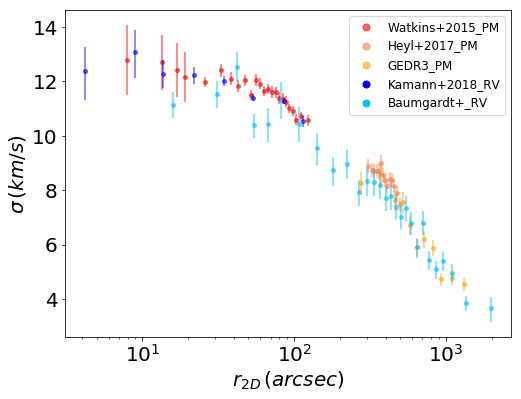

In [3]:
##Plotting
rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
                  markersize=7, alpha=0.6, label='Watkins+2015_PM')
cdot=mlines.Line2D([], [],  linestyle = 'None', color='coral', marker='o',
                  markersize=7, alpha=0.6, label='Heyl+2017_PM')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label='GEDR3_PM')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='blue', marker='o',
                  markersize=7, label='Kamann+2018_RV')
sbdot=mlines.Line2D([], [],  linestyle = 'None', color='deepskyblue', marker='o',
                  markersize=7, label='Baumgardt+_RV')


matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(figsize = (8, 6))
axs.errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'red')
axs.scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'red')

sigma_bg_err = (del_sigmau_bg+del_sigmad_bg)/2.
axs.scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'orange')
axs.errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'orange')

axs.scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'coral')
axs.errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'coral')

sigma_bg_rv_err = (del_sigmau_bg_rv + del_sigmad_bg_rv)/2.
axs.scatter(r_bg_rv, sigma_bg_rv, s=15, alpha = 0.6, color = 'deepskyblue')
axs.errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o',markersize=0.01, alpha=0.6, color = 'deepskyblue')

sigma_ka_err = (sigma_ka_plus + sigma_ka_minus)/2.
axs.scatter(r_ka, sigma_ka, s=15, alpha = 0.6, color = 'blue')
axs.errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o',markersize=0.01, alpha=0.6, color = 'blue')


axs.set_xscale('log')
axs.set_xlabel(r'$r_{2D}\,(arcsec)$')
axs.set_ylabel(r'$\sigma\,(km/s)$')
#axs.legend(loc = 'best')
axs.legend(handles=[rdot, cdot, odot, bdot,sbdot], loc='best', prop={'size': 12}, numpoints=1, frameon=True)

In [3]:
##Read in N-body fit and MOCHA fit data
xls_nbody = pd.ExcelFile('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Baumgardt_Nbody_fit_47Tuc.xlsx')
xls_mocha = pd.ExcelFile('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Giersz_MOCHAfit_47Tuc.xlsx')
df_nb_nuv = pd.read_excel(xls_nbody, 'Sheet1', names = ['r_arcsec', 'nu_v'])
df_nb_pm = pd.read_excel(xls_nbody, 'Sheet2', names = ['r_arcsec', 'pm'])
df_nb_rv = pd.read_excel(xls_nbody, 'Sheet3', names = ['r_arcsec', 'rv'])
df_mc_nuv = pd.read_excel(xls_mocha, 'Sheet1', names = ['r_arcsec', 'nu_v'])
df_mc_rv = pd.read_excel(xls_mocha, 'Sheet2', names = ['r_arcsec', 'rv', 'r_arcmin'])

In [2]:
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon_rt171/'
snap_h5 = 'initial.snapshots.h5'

with pd.HDFStore(path+snap_h5) as snap_hdf:
    snap_keys = np.sort(snap_hdf.keys())

#print(snap_keys)    
#max_snapno = len(snap_keys)    
    
t_conv = dyn.conv('t', path+'initial.conv.sh')

def read_keys(thekey):
    return re.findall(r'\d+\.\d+|\d+', thekey)

snapno = []; snaptime = []
for ii in range(len(snap_keys)):
    theno = read_keys(snap_keys[ii])[0]; thetime = read_keys(snap_keys[ii])[1]
    snapno.append(int(theno)); snaptime.append(thetime)
    
snapno_sort, snaptime_sort = (np.array(t) for t in zip(*sorted(zip(snapno, snaptime))))
#print(snapno_sort)
np.savetxt(path+'snap_keys.txt',
          np.c_[snapno_sort, snaptime_sort], fmt = '%s %s', header = '1.snap_no 2.snap_time', comments = '#')
#read_keys(snap_keys[100])

In [4]:
snap = cmct.Snapshot(fname=path+snap_h5, snapshot_name='/649(t=0.62166912)', conv=path+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)
#print(snap.data['a_AU'], snap.data['e'])

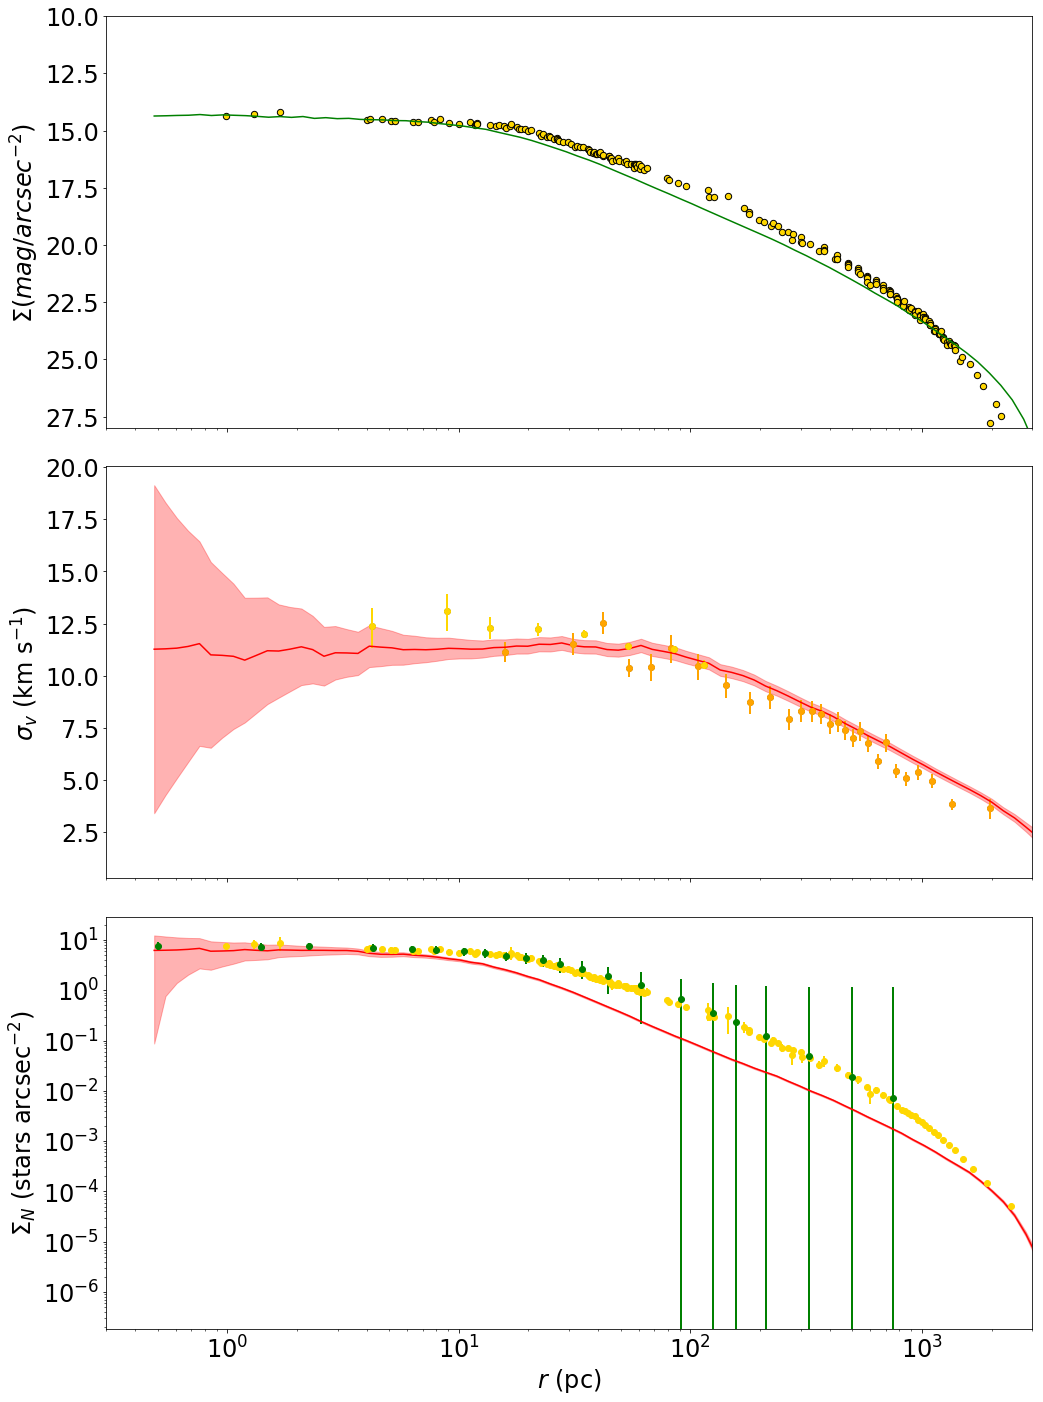

In [5]:
##First Check

##Surface brightness and Velocity dispersion profile
E_BV = 0.04
d47 = 4.52  ##kpc
Av = 3.1*E_BV


###############################################
##Make surface brightness profile
snap.add_photometry('/projects/b1095/syr904/MyCodes/cmctoolkit/filt_index.txt')
v_bincenter, v_profile = snap.make_smoothed_brightness_profile('V', bins=80,
                                                               min_mass=None, max_mass=None,
                                                               max_lum=12, fluxdict=None,
                                                               startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                               min_logr=-2.0)


# Make velocity dispersion profiles
star_velbin_center, star_veldisp_profile, star_e_veldisp_profile = snap.make_smoothed_veldisp_profile(bins=80,
                                                                 min_mass=0.85,
                                                                 max_mass=None,
                                                                 dmax=None,
                                                                 fluxdict=None,
                                                                 startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                                 min_logr=-2.0)

star_velbin_arcsec = conversions.pc_to_arcsec(star_velbin_center,d47)


##Make number density profile
star_numbin_center, star_profile, star_e_profile = snap.make_smoothed_number_profile(bins=80,
                                                 min_mass=0.85,
                                                 max_mass=None,
                                                 fluxdict=None,
                                                 startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                 min_logr=-2.0)

star_numbin_arcsec = conversions.pc_to_arcsec(star_numbin_center,d47)
star_profile_arcsec = star_profile/(conversions.pc_to_arcsec(1.,d47)**2)
star_e_profile_arcsec = star_e_profile/(conversions.pc_to_arcsec(1.,d47)**2)



##Plotting
fig, ax = plt.subplots(nrows = 3, figsize = (15, 20), sharex = True)
ax[0].scatter(10**arcsec_t, SB_t,facecolor='gold',edgecolor='black',s=40,label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].plot(v_bincenter, v_profile, c='g', label='V')
#ax[0].legend(loc='lower left')
#ax[0].set_xlabel('$r$ (arcsec)')
ax[0].set_ylabel(r'$\Sigma (mag/arcsec^{-2})$')
ax[0].set_xscale('log')
ax[0].set_xlim(0.3, 3e3)
ax[0].set_ylim(28, 10)


ax[1].scatter(r_bg_rv, sigma_bg_rv, s=30, color = 'orange',edgecolor='black')
ax[1].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o', lw = 2.0, color = 'orange')
ax[1].scatter(r_ka, sigma_ka, s=30, color = 'gold', edgecolor='black')
ax[1].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o', lw=2.0, color = 'gold')
ax[1].plot(star_velbin_arcsec, star_veldisp_profile, c='r', label='Stars')
ax[1].fill_between(star_velbin_arcsec, star_veldisp_profile - star_e_veldisp_profile,
                                  star_veldisp_profile + star_e_veldisp_profile, color='r', alpha=0.3)
#ax[1].legend(loc='lower left')
#ax[1].set_xlabel('$r$ (arcsec)')
ax[1].set_ylabel('$\sigma_v$ (km s$^{-1}$)')
ax[1].set_xscale('log')


ax[2].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
                      fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
ax[2].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
                      c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')
ax[2].plot(star_numbin_arcsec, star_profile_arcsec, c='r', label='Stars')
ax[2].fill_between(star_numbin_arcsec, star_profile_arcsec - star_e_profile_arcsec,
                                  star_profile_arcsec + star_e_profile_arcsec, color='r', alpha=0.3)

#ax[2].legend(loc='lower left')
ax[2].set_xlabel('$r$ (pc)')
ax[2].set_ylabel('$\Sigma_N$ (stars arcsec$^{-2}$)')
ax[2].set_xscale('log')
ax[2].set_yscale('log')

fig.tight_layout()

In [7]:
##Select best-fit snapshot
E_BV = 0.04
d47 = 4.52  ##kpc
Av = 3.1*E_BV

# Pull all snapshots to be searched
sbp_files = np.sort(glob(path+'SBP*_LCUT12.txt'))
vdp_files = np.sort(glob(path+'VDP*_MCUT0d85.txt'))
ndp_files = np.sort(glob(path+'NDP*_MCUT0d85.txt'))
#print(sbp_files, vdp_files)


# Read data SBP, VDP
# SBP uncertainty calculation follows that of McLaughlin & van der Marel 2005,
# and we remove points with infinite uncertainty ("goodness" 0)
rarcsec_trager = data_t['r[ARCSEC]']
sbp_trager = data_t['s[MAG/ARCSEC2]']
sbperr_trager = data_t['e_s[MAG/ARCSEC2]']

r_trag = rarcsec_trager[~np.isnan(sbperr_trager)]
sbp_trag = sbp_trager[~np.isnan(sbperr_trager)]
sbperr_trag = sbperr_trager[~np.isnan(sbperr_trager)]

r_rvpm = list(r_wk) + list(r_hy) + list(r_bg) + list(r_bg_rv) + list(r_ka)
vel_rvpm = list(sigma_wk_kms) + list(sigma_bg) + list(sigma_hy_kms) + list(sigma_bg_rv) + list(sigma_ka)
velerr_rvpm_u = list(sigma_wk_err_kms) + list(del_sigmau_bg) + list(sigma_hy_err_kms[0]) + list(del_sigmau_bg_rv) + list(sigma_ka_plus)
velerr_rvpm_d = list(sigma_wk_err_kms) + list(del_sigmad_bg) + list(sigma_hy_err_kms[1]) + list(del_sigmad_bg_rv) + list(sigma_ka_minus)

r_rvpm_sort, vel_rvpm_sort = (np.array(t) for t in zip(*sorted(zip(r_rvpm, vel_rvpm))))
r_rvpm_sort, velerr_rvpm_u_sort = (np.array(t) for t in zip(*sorted(zip(r_rvpm, velerr_rvpm_u))))
r_rvpm_sort, velerr_rvpm_d_sort = (np.array(t) for t in zip(*sorted(zip(r_rvpm, velerr_rvpm_d))))


# Calculate normalized chi square on all files
sbp_rchisq_list = np.array([])
vdp_rchisq_list = np.array([])

for ii in range(len(sbp_files)):
    sbp_ii = np.genfromtxt(sbp_files[ii])
    vdp_ii = np.genfromtxt(vdp_files[ii])
    
    # Interpolate SBP and VDP to calculate chisq
    sbp_interp = interp1d(sbp_ii[:,0], Av+sbp_ii[:,1], bounds_error=False, fill_value=(sbp_ii[:,1][0], 0))
    vdp_interp = interp1d(vdp_ii[:,0], vdp_ii[:,1], bounds_error=False, fill_value=(vdp_ii[:,1][0], 0))
    
    sbp_chisq = np.sum((sbp_trag - sbp_interp(r_trag)) ** 2 / sbperr_trag ** 2)
    
    
    data_above = np.where(vel_rvpm_sort > vdp_interp(r_rvpm_sort)) # treat upper and lower error bars differently
    data_below = np.where(vel_rvpm_sort < vdp_interp(r_rvpm_sort))
    vdp_chisq1 = np.sum((vel_rvpm_sort[data_above] - vdp_interp(r_rvpm_sort[data_above])) ** 2 / velerr_rvpm_d_sort[data_above] ** 2)
    vdp_chisq2 = np.sum((vel_rvpm_sort[data_below] - vdp_interp(r_rvpm_sort[data_below])) ** 2 / velerr_rvpm_u_sort[data_below] ** 2)
    
    sbp_rchisq = sbp_chisq / len(r_trag)
    vdp_rchisq = (vdp_chisq1 + vdp_chisq2) / len(r_rvpm_sort)
    
    sbp_rchisq_list = np.append(sbp_rchisq_list, sbp_rchisq)
    vdp_rchisq_list = np.append(vdp_rchisq_list, vdp_rchisq)
    
    #print(f'Done {ii+1} snapshots of {len(sbp_files)}')
        
print(sbp_rchisq_list, vdp_rchisq_list)

[12.18540031 11.88217123 11.61098634 11.36629073 11.28529069 11.00807096
 10.59730546 10.31963328 10.22275205  9.89501258  9.94595414  9.71241579
  9.51111652  9.48697609  9.31314784  9.33836103  9.12732525  9.27272228
  9.01429935  8.92947554  8.91773566  9.08763988  9.13676494  9.24219173
  9.17768844  9.48423425  9.62966887  9.70680928  9.73088809  9.91615944
 10.01350892 10.43278709 10.64749477 10.99574485 11.3437267  11.62358672
 11.9727108  12.31222773 12.69229987 13.33792685 13.88778684 14.88779758
 15.42754556 15.64843278 16.38307982 16.86480712 17.77600756 18.86963005
 19.67409545 20.40958632 21.51774882 22.58976173 22.83371991 23.17420466
 23.74227117 25.15344068 25.81497252 27.2758725  28.49376723 29.33338147
 29.67375594 30.75914379 32.03114646 33.08917312 33.81655132] [20.2320338  20.22680354 19.78694997 19.62750202 19.81773578 19.85347421
 18.80443698 19.09952651 18.57147958 18.282949   18.30155926 18.11197903
 18.02077232 18.13528723 17.22905909 17.20830975 17.12415877 1

(array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),) [25.78455224 25.93239819 26.10505554 26.42790118 26.84201178 26.93455728
 27.20507633 27.58876422 27.70489825 28.21055937 28.63004746 29.27355682
 30.26581129 30.78373231 31.22692167]
29 43
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/SBP702_LCUT12.txt
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/SBP730_LCUT12.txt
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/SBP702_LCUT12.txt


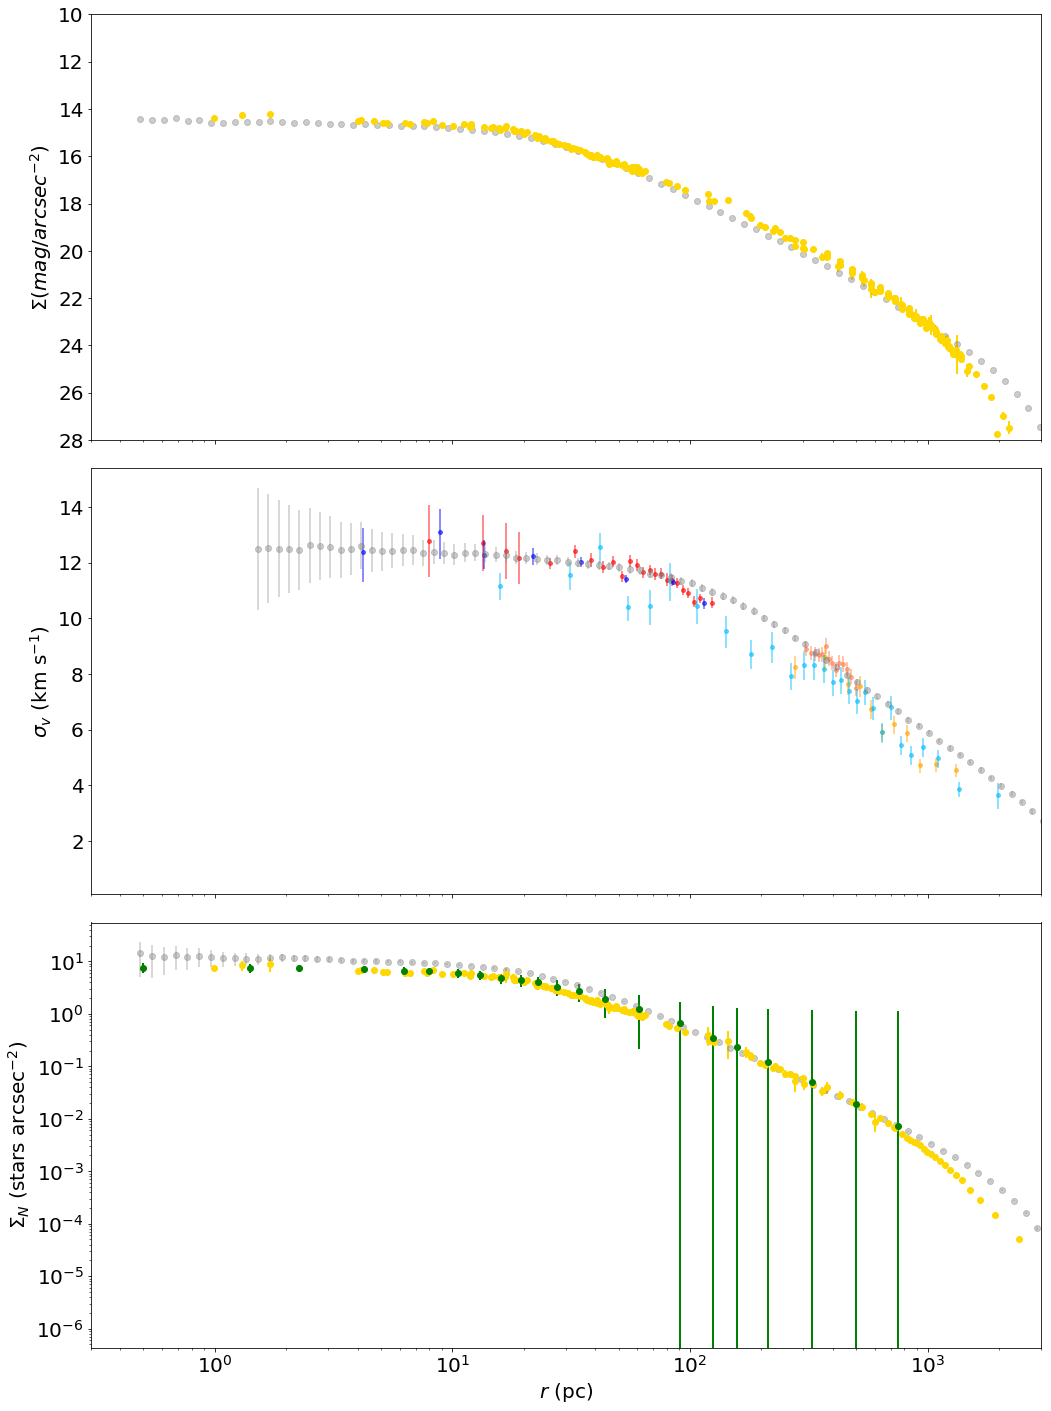

In [46]:
##Selecting good fit snaps and Plotting
snap_good_fit = np.where(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0) < 16)
snap_best_fit1 = np.min((np.array(sbp_rchisq_list)+np.array(vdp_rchisq_list))[snap_good_fit])
snap_best_fit2 = np.max((np.array(sbp_rchisq_list)+np.array(vdp_rchisq_list))[snap_good_fit])
tot_rchisq_list = (np.array(sbp_rchisq_list)+np.array(vdp_rchisq_list))[snap_good_fit]
print(snap_good_fit, tot_rchisq_list)

best_snap1 = snap_good_fit[0][np.where(tot_rchisq_list == snap_best_fit1)[0][0]]
best_snap2 = snap_good_fit[0][np.where(tot_rchisq_list == snap_best_fit2)[0][0]]
print(best_snap1, best_snap2)


##Plotting
fig, ax = plt.subplots(nrows = 3, figsize = (15, 20), sharex = True)
#ax[0].scatter(10**arcsec_t, SB_t,facecolor='gold',edgecolor='black',s=40,label=r'$\rm{Trager\,et\,al.\,1995}$')
#ax[0].scatter(r_trag, sbp_trag, facecolor='gold',edgecolor='black',s=30,
#              label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].errorbar(r_trag, sbp_trag, yerr = sbperr_trag, fmt='o', lw = 2.0, color = 'gold',
               label=r'$\rm{Trager\,et\,al.\,1995}$')

ax[1].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'red')
ax[1].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'red')

ax[1].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'orange')
ax[1].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'orange')

ax[1].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'coral')
ax[1].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'coral')

ax[1].scatter(r_bg_rv, sigma_bg_rv, s=15, alpha = 0.6, color = 'deepskyblue')
ax[1].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o',markersize=0.01, alpha=0.6, color = 'deepskyblue')

ax[1].scatter(r_ka, sigma_ka, s=15, alpha = 0.6, color = 'blue')
ax[1].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o',markersize=0.01, alpha=0.6, color = 'blue')

ax[2].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
                      fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
ax[2].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
                      c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')


#for xx in range(len(snap_good_fit[0])):
#    sbp_t = np.genfromtxt(np.array(sbp_files)[snap_good_fit][xx])
#    sbp_r = sbp_t[:,0]
#    sbp_s = sbp_t[:,1] + Av
#    
#    ax[0].plot(sbp_r, sbp_s, c='gray', alpha = 0.4)
#    
#    vdp_t = np.genfromtxt(np.array(vdp_files)[snap_good_fit][xx])
#    vdp_r = vdp_t[:,0]
#    vdp_s = vdp_t[:,1]
#    vdp_e = ndp_t[:,2]
#    
#    
#    ax[1].plot(vdp_r, vdp_s, c='gray', alpha = 0.4)
#    
#    ndp_t = np.genfromtxt(np.array(ndp_files)[snap_good_fit][xx])
#    ndp_r = ndp_t[:,0]
#    ndp_s = ndp_t[:,1]
#    ndp_e = ndp_t[:,2]
#    
#    ax[2].plot(ndp_r, ndp_s, c='gray', alpha = 0.4)

best_snap = 29
print(np.array(sbp_files)[best_snap1])
print(np.array(sbp_files)[best_snap2])
print(np.array(sbp_files)[best_snap])

sbp_t = np.genfromtxt(np.array(sbp_files)[best_snap])
sbp_r = sbp_t[:,0]
sbp_s = sbp_t[:,1] + Av

ax[0].scatter(sbp_r, sbp_s, c='gray', zorder = 2, alpha = 0.4)

vdp_t = np.genfromtxt(np.array(vdp_files)[best_snap])
vdp_r = vdp_t[:,0]
vdp_s = vdp_t[:,1]
vdp_e = vdp_t[:,2]

ax[1].scatter(vdp_r, vdp_s, c='gray', alpha = 0.4, zorder=2)
ax[1].errorbar(vdp_r, vdp_s, yerr = vdp_e, c='gray', fmt='o', markersize=0.01, zorder=2, alpha = 0.4)

ndp_t = np.genfromtxt(np.array(ndp_files)[best_snap])
ndp_r = ndp_t[:,0]
ndp_s = ndp_t[:,1]
ndp_e = ndp_t[:,2]

ax[2].scatter(ndp_r, ndp_s, c='gray', alpha = 0.4, zorder=2)
ax[2].errorbar(ndp_r, ndp_s, yerr = ndp_e, c='gray', fmt='o',markersize=0.01, zorder=2, alpha = 0.4)
    

ax[0].set_ylabel(r'$\Sigma (mag/arcsec^{-2})$')
ax[0].set_xscale('log')
ax[0].set_xlim(0.3, 3e3)
ax[0].set_ylim(28, 10)
#ax[0].legend(loc='lower left')
#ax[0].set_xlabel('$r$ (arcsec)')

ax[1].set_ylabel('$\sigma_v$ (km s$^{-1}$)')
ax[1].set_xscale('log')
#ax[1].legend(loc='lower left')
#ax[1].set_xlabel('$r$ (arcsec)')

#ax[2].legend(loc='lower left')
ax[2].set_xlabel('$r$ (pc)')
ax[2].set_ylabel('$\Sigma_N$ (stars arcsec$^{-2}$)')
ax[2].set_xscale('log')
ax[2].set_yscale('log')

fig.tight_layout()

In [4]:
##Select best-fit snapshot
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/old_IC/MOCHA47Tuc_elson_rv4_3e6_tcon_oldIC_rmax50/'

E_BV = 0.04
d47 = 4.52  ##kpc
Av = 3.1*E_BV

# Pull all snapshots to be searched
sbp_files = np.sort(glob(path+'initial.snap*.2D_SBPLcut12_NCUT0.85.dat'))
vdp_files = np.sort(glob(path+'initial.snap*.vel_dispersion_vr_pm_700_0.85.dat'))


# Read data SBP, VDP
# SBP uncertainty calculation follows that of McLaughlin & van der Marel 2005,
# and we remove points with infinite uncertainty ("goodness" 0)
rarcsec_trager = data_t['r[ARCSEC]']
sbp_trager = data_t['s[MAG/ARCSEC2]']
sbperr_trager = data_t['e_s[MAG/ARCSEC2]']

r_trag = rarcsec_trager[~np.isnan(sbperr_trager)]
sbp_trag = sbp_trager[~np.isnan(sbperr_trager)]
sbperr_trag = sbperr_trager[~np.isnan(sbperr_trager)]

r_rvpm = list(r_wk) + list(r_hy) + list(r_bg) + list(r_bg_rv) + list(r_ka)
vel_rvpm = list(sigma_wk_kms) + list(sigma_bg) + list(sigma_hy_kms) + list(sigma_bg_rv) + list(sigma_ka)
velerr_rvpm_u = list(sigma_wk_err_kms) + list(del_sigmau_bg) + list(sigma_hy_err_kms[0]) + list(del_sigmau_bg_rv) + list(sigma_ka_plus)
velerr_rvpm_d = list(sigma_wk_err_kms) + list(del_sigmad_bg) + list(sigma_hy_err_kms[1]) + list(del_sigmad_bg_rv) + list(sigma_ka_minus)

r_rvpm_sort, vel_rvpm_sort = (np.array(t) for t in zip(*sorted(zip(r_rvpm, vel_rvpm))))
r_rvpm_sort, velerr_rvpm_u_sort = (np.array(t) for t in zip(*sorted(zip(r_rvpm, velerr_rvpm_u))))
r_rvpm_sort, velerr_rvpm_d_sort = (np.array(t) for t in zip(*sorted(zip(r_rvpm, velerr_rvpm_d))))


# Calculate normalized chi square on all files
sbp_rchisq_list = np.array([])
vdp_rchisq_list = np.array([])

for ii in range(len(sbp_files)):
    sbp_ii = np.genfromtxt(sbp_files[ii])
    vdp_ii = np.genfromtxt(vdp_files[ii])
    
    r_sbp = uc.pc2arcsec(d47, sbp_ii[:,1]); sigma_sbp = conversions.SB_converter(sbp_ii[:,3])
    r_vdp = uc.pc2arcsec(d47, vdp_ii[:,0])
    
    # Interpolate SBP and VDP to calculate chisq
    ##Note I did not include Av here
    sbp_interp = interp1d(r_sbp, sigma_sbp+Av, bounds_error=False, fill_value=(sigma_sbp[0], 0))
    vdp_interp = interp1d(r_vdp, vdp_ii[:,1], bounds_error=False, fill_value=(vdp_ii[:,1][0], 0))
    
    sbp_chisq = np.sum((sbp_trag - sbp_interp(r_trag)) ** 2 / sbperr_trag ** 2)
    
    
    data_above = np.where(vel_rvpm_sort > vdp_interp(r_rvpm_sort)) # treat upper and lower error bars differently
    data_below = np.where(vel_rvpm_sort < vdp_interp(r_rvpm_sort))
    vdp_chisq1 = np.sum((vel_rvpm_sort[data_above] - vdp_interp(r_rvpm_sort[data_above])) ** 2 / velerr_rvpm_d_sort[data_above] ** 2)
    vdp_chisq2 = np.sum((vel_rvpm_sort[data_below] - vdp_interp(r_rvpm_sort[data_below])) ** 2 / velerr_rvpm_u_sort[data_below] ** 2)
    
    sbp_rchisq = sbp_chisq / len(r_trag)
    vdp_rchisq = (vdp_chisq1 + vdp_chisq2) / len(r_rvpm_sort)
    
    sbp_rchisq_list = np.append(sbp_rchisq_list, sbp_rchisq)
    vdp_rchisq_list = np.append(vdp_rchisq_list, vdp_rchisq)
    
    #print(f'Done {ii+1} snapshots of {len(sbp_files)}')
        
print(sbp_rchisq_list, vdp_rchisq_list)

##Selecting good fit snaps and Plotting
snap_good_fit = np.where(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0) < 17.5)[0]
snap_best_fit1 = np.min((np.array(sbp_rchisq_list)+np.array(vdp_rchisq_list))[snap_good_fit])
snap_best_fit2 = np.max((np.array(sbp_rchisq_list)+np.array(vdp_rchisq_list))[snap_good_fit])
tot_rchisq_list = (np.array(sbp_rchisq_list)+np.array(vdp_rchisq_list))[snap_good_fit]
print(snap_good_fit, tot_rchisq_list)
print(snap_best_fit1, snap_best_fit2)

best_snap1 = snap_good_fit[np.where(tot_rchisq_list == snap_best_fit1)[0]][0]
best_snap2 = snap_good_fit[np.where(tot_rchisq_list == snap_best_fit2)[0]][0]
print(best_snap1, best_snap2)

#best_snap = 8
print(np.array(sbp_files)[best_snap1])
print(np.array(sbp_files)[best_snap2])
#print(np.array(sbp_files)[best_snap])

sum_rchisq_list = np.array(sbp_rchisq_list)+np.array(vdp_rchisq_list)
snap_min = np.min(sum_rchisq_list)
#print(sum_rchisq_list)
#print(snap_min)
best_min = np.where(sum_rchisq_list == snap_min)[0]
print(best_min, np.array(sbp_files)[best_min])

[14.57810177 14.53842203 13.9975602  14.7804486  14.62119656 14.8572794
 14.63307764 15.10735681 15.42291807 16.05317824 16.44923088 16.95071041
 16.51317214 17.43377607 17.31428433 17.50057718 18.88160087 18.86947443
 19.03082306 20.13670293 20.63883803 19.82480995 21.86509902 22.44057978
 23.36613578 24.52874513 24.33499396 25.80014995 28.6838693  28.28738917] [19.79390271 19.30502858 19.32034232 19.94450536 18.44092007 19.29699757
 19.10173633 18.16639516 18.05731602 18.44263118 17.07287773 17.25816706
 18.28793998 17.82439826 19.34053189 18.81653064 18.51386359 17.94604692
 17.30343729 17.34513351 16.57332991 16.68436979 17.50622081 16.09084671
 15.9877099  17.14871351 17.5626721  18.34320154 17.78465774 18.11190122]
[10 11] [33.52210861 34.20887747]
33.52210860764875 34.20887747294732
10 11
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/old_IC/MOCHA47Tuc_elson_rv4_3e6_tcon_oldIC_rmax50/initial.snap587.2D_SBPLcut12_NCUT0.85.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/m

#t=10293.3

11.71124361848


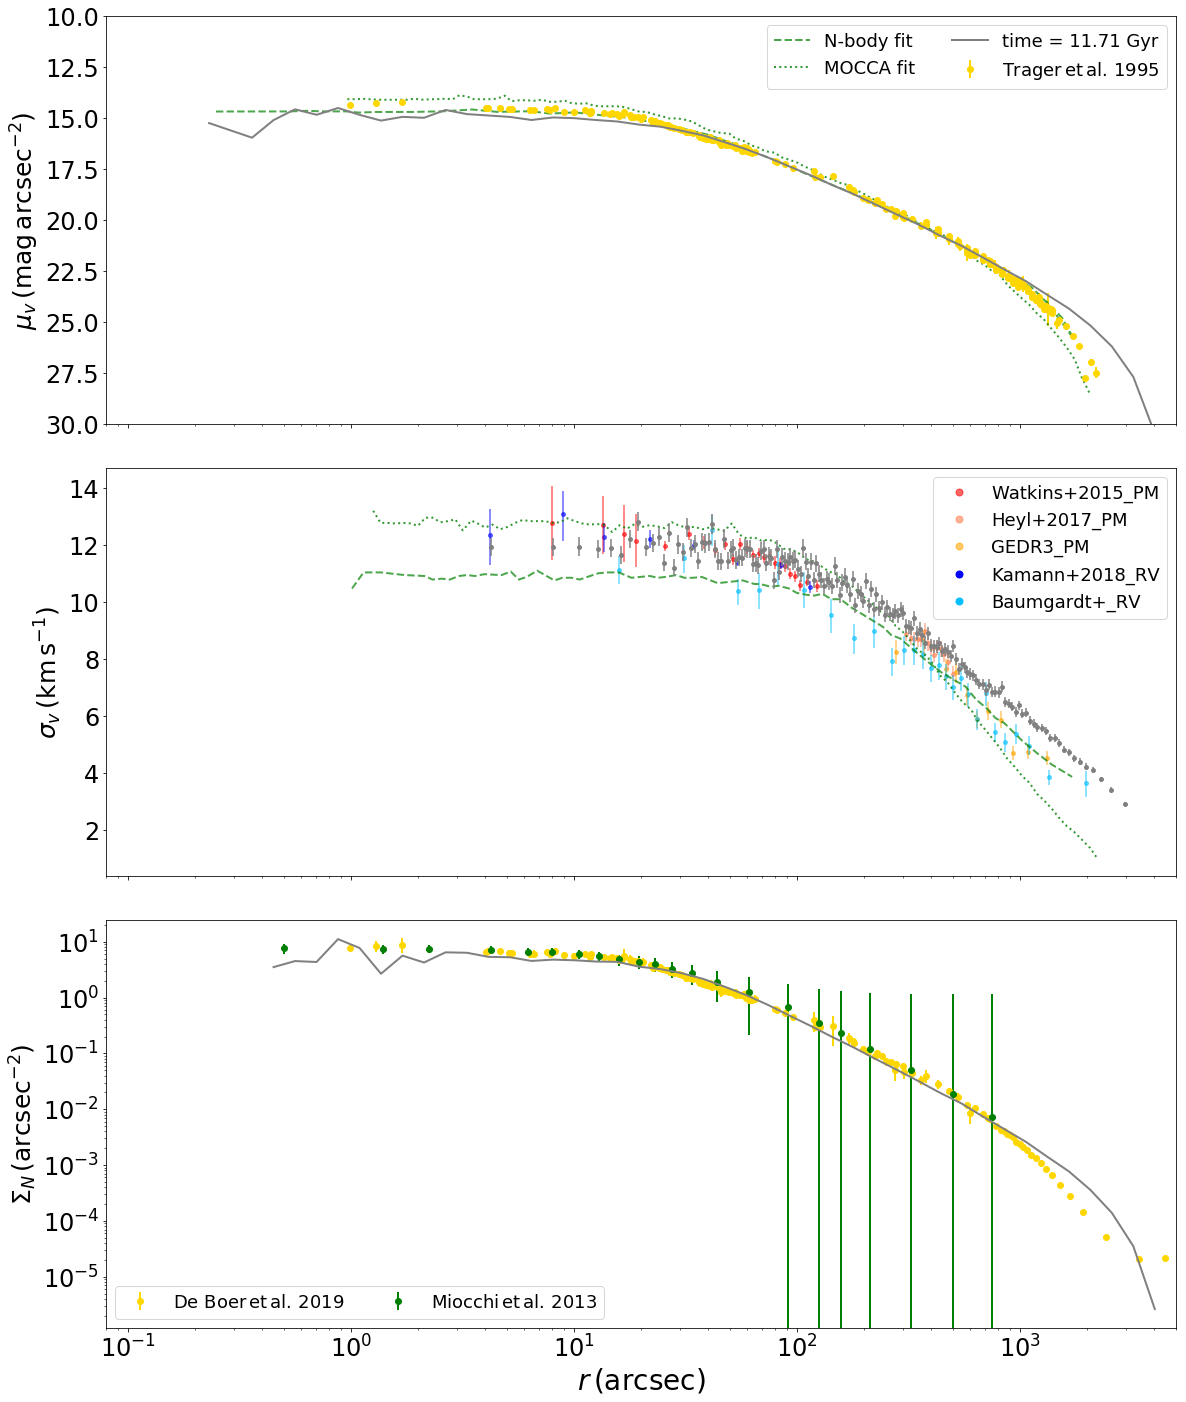

In [5]:
##Model paths: TC_on
R_sun_obs=4.52

t_conv = dyn.conv('t', path+'initial.conv.sh')


######################################################
##Model data
snap2D = path+'initial.snap587.2Dproj.dat.gz'
#print(snap2D)
snap2D_Ltot = path+'initial.snap587.2D_SBP_NCUT0.85.dat'
snap2D_L15 = path+'initial.snap587.2D_SBPLcut12_NCUT0.85.dat'
#snap_veldisp = path+'initial.snap0529.vel_dispersion_giants_vr_pm_700_0.8.dat'
snap_veldisp = path+'initial.snap587.vel_dispersion_vr_pm_700_0.85.dat'
#print(snap_giant)

    
with gzip.open(snap2D, 'r') as f2D:
    first_line=f2D.readline().decode('utf8')
    
    print(first_line)
            
    t_gyr = 0.53090065*t_conv/1000.
    print(t_gyr) 

data5 = np.genfromtxt(snap2D_L15)
arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
SB = conversions.SB_converter(data5[:,3])
SBerr = data5[:,6]/data5[:,5]*SB
SD = conversions.SD_converter(data5[:,5], R_sun_obs)
SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)

data_nd = np.genfromtxt(snap2D_Ltot)
ND = conversions.SD_converter(data_nd[:,7], R_sun_obs)
NDerr = conversions.SD_converter(data_nd[:,8], R_sun_obs)

        
arcsec_cut = []
SB_cut = []
SBerr_cut = []

for k in range(len(SB)):
    if arcsec[k] < 10 and SB[k] > 20:
        Nothing = 0
    else:
        arcsec_cut.append(arcsec[k])
        SB_cut.append(SB[k])
        #SBerr_cut.append(SBerr[k])
            
            
    
arcsec_nd_cut = []
ND_cut = []
for j in range(len(ND)):
    if ND[j]==0:
        continue
    else:
        ND_cut.append(ND[j])
        arcsec_nd_cut.append(arcsec[j])
        
                

data_vel = np.genfromtxt(snap_veldisp)
R_model = conversions.pc_to_arcsec(data_vel[:,0],R_sun_obs)
sigma_model = data_vel[:,1]
sigma_err_model = data_vel[:,2]


####################################################      
##Plotting        
rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
                  markersize=7, alpha=0.6, label='Watkins+2015_PM')
cdot=mlines.Line2D([], [],  linestyle = 'None', color='coral', marker='o',
                  markersize=7, alpha=0.6, label='Heyl+2017_PM')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label='GEDR3_PM')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='blue', marker='o',
                  markersize=7, label='Kamann+2018_RV')
sbdot=mlines.Line2D([], [],  linestyle = 'None', color='deepskyblue', marker='o',
                  markersize=7, label='Baumgardt+_RV')

fig, ax=plt.subplots(nrows = 3, sharex=True, sharey=False, figsize=(17,20))

########################
##Plotting in observed data 
ax[0].errorbar(r_trag, sbp_trag, yerr = sbperr_trag, fmt='o', lw = 2.0, color = 'gold',
               label=r'$\rm{Trager\,et\,al.\,1995}$')

ax[1].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'red')
ax[1].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'red')

ax[1].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'orange')
ax[1].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'orange')

ax[1].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'coral')
ax[1].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'coral')

ax[1].scatter(r_bg_rv, sigma_bg_rv, s=15, alpha = 0.6, color = 'deepskyblue')
ax[1].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o',markersize=0.01, alpha=0.6, color = 'deepskyblue')

ax[1].scatter(r_ka, sigma_ka, s=15, alpha = 0.6, color = 'blue')
ax[1].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o',markersize=0.01, alpha=0.6, color = 'blue')

ax[2].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
                      fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
ax[2].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
                      c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')

#######################
##Plotting model data
ax[0].plot(arcsec_cut, np.array(SB_cut), color = 'gray', lw=2, zorder = 3)
ax[1].scatter(R_model, sigma_model,s=15, color = 'gray', zorder=3)
ax[1].errorbar(R_model,sigma_model,yerr=sigma_err_model, color = 'gray', fmt='o',markersize=0.01,zorder=3)
ax[2].plot(arcsec_nd_cut, ND_cut, lw=2, color = 'gray', zorder = 3)
#ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
#ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)


#######################
##Plotting other model fit data
ax[0].plot(df_nb_nuv['r_arcsec'], df_nb_nuv['nu_v'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
ax[0].plot(df_mc_nuv['r_arcsec'], df_mc_nuv['nu_v'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')

ax[1].plot(df_nb_rv['r_arcsec'], df_nb_rv['rv'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
ax[1].plot(df_mc_rv['r_arcsec'], df_mc_rv['rv'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')


#######################
ax[0].plot([10000,10000],[-5,-5], lw=2, color = 'gray', label='time = '+str(round(t_gyr, 2))+' Gyr')
#ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].set_xscale('log')
ax[0].set_xlim(0.08,5000)
ax[0].set_ylim(30,10)
#ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
ax[0].set_ylabel(r'$\mu_v\,(\rm{mag\, arcsec^{-2}})$',fontsize=25)
ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})
    

ax[1].set_xscale('log')
ax[1].set_xlim(0.08,5000)
#ax2.set_ylim(0,10)
#ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=25)
#ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
ax[1].legend(handles=[rdot, cdot, odot, bdot,sbdot], loc='best', prop={'size': 18}, numpoints=1, frameon=True)
    
    
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
ax[2].set_ylabel(r'$\Sigma_N\,(\rm{arcsec^{-2}})$', fontsize=25)
#ax[1][x].set_ylim(0, 35)
ax[2].legend(loc=3, scatterpoints=1, ncol=2, prop={'size': 18})
        
        
        
fig.tight_layout()
#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/SBP_VDP_NDP_Elson.pdf', dpi=300)

[12.78139627 12.71150694 12.4116296  12.16532752 11.97247252 12.40680032
 12.10080483 11.84479479 12.03729717 11.50704069 12.06236363 11.91415413
 11.6484087  11.73156633 11.59625048 11.59996671 11.39107641 11.3630746
 11.26310402 11.01080918 10.90703997 10.60108421 10.71529238 10.56623136]


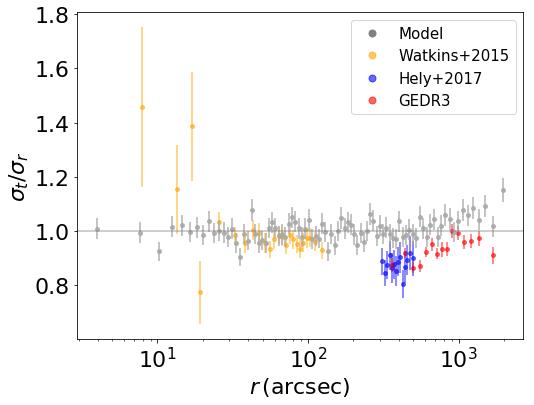

In [7]:
##Comapring proper motions
distance = 4.52 ##kpc
dec_47 = -(72.+4.*60.+52.7*3600)*np.pi/180.

def err_sigma(f, a, b, sigma_a, sigma_b, err_a, err_b):   ##f = sqrt(a*A^2+b*B^2)
    return np.sqrt((sigma_a/f)**2*a**2*err_a**2 + (sigma_b/f)**2*b**2*err_b**2)

def err_ratio(f, sigma_a, sigma_b, err_a, err_b):   ##f = A/B
    return np.abs(f)*np.sqrt((err_a/sigma_a)**2 + (err_b/sigma_b)**2)
    

##From Watkins_2015
df_watkins = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/watkins2015_pm.txt', dtype = str)
gc_name_wk = df_watkins[:,0]
r_wk = df_watkins[:,3][gc_name_wk == 'NGC0104'].astype(np.float)  ##in arcsec
r_wk_err = df_watkins[:,4][gc_name_wk == 'NGC0104'].astype(np.float)
sigma_wk = df_watkins[:,5][gc_name_wk == 'NGC0104'].astype(np.float)  ##in mas/yr
sigma_wk_err = df_watkins[:,6][gc_name_wk == 'NGC0104'].astype(np.float)
tr_ratio_wk = df_watkins[:,7][gc_name_wk == 'NGC0104'].astype(np.float)
tr_ratio_err_wk = df_watkins[:,8][gc_name_wk == 'NGC0104'].astype(np.float)

##From Heyl_2017
df_heyl = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/heyl2017_pm.xlsx',
                        names = ['r_proj', 'sigmar_u', 'sigmar_d', 'sigmat_u', 'sigmat_d'])
r_hy = df_heyl['r_proj']*60.  ##in arcsec
sigmar_hy_u = df_heyl['sigmar_u']; sigmar_hy_d = df_heyl['sigmar_d']  ##in mas/yr
sigmat_hy_u = df_heyl['sigmat_u']; sigmat_hy_d = df_heyl['sigmat_d']  ##in mas/yr
sigmar_hy = (sigmar_hy_u+sigmar_hy_d)/2.; sigmar_hy_err = [sigmar_hy_u-sigmar_hy, sigmar_hy-sigmar_hy_d]
sigmat_hy = (sigmat_hy_u+sigmat_hy_d)/2.; sigmat_hy_err = [sigmat_hy_u-sigmat_hy, sigmat_hy-sigmat_hy_d]

sigma_hy = np.sqrt(sigmar_hy**2+sigmat_hy**2)/np.sqrt(2)
sigma_hy_err = [[],[]]
sigma_hy_err[0] = err_sigma(sigma_hy, 0.5, 0.5, sigmar_hy, sigmat_hy, sigmar_hy_err[0], sigmat_hy_err[0])
sigma_hy_err[1] = err_sigma(sigma_hy, 0.5, 0.5, sigmar_hy, sigmat_hy, sigmar_hy_err[1], sigmat_hy_err[1])
tr_ratio_hy = np.array(sigmat_hy)/np.array(sigmar_hy)
tr_ratio_hy_err = [[],[]]
tr_ratio_hy_err[0] = err_ratio(tr_ratio_hy, sigmat_hy, sigmar_hy, sigmat_hy_err[0], sigmar_hy_err[0])
tr_ratio_hy_err[1] = err_ratio(tr_ratio_hy, sigmat_hy, sigmar_hy, sigmat_hy_err[1], sigmar_hy_err[1])



##From Gaia EDR3
df_bg = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Baumgardt_vel_dispersion_profile_47Tuc.xlsx',
                      names = ['name1', 'name2', 'r_proj', 'sigma', 'del_sigma_up', 'del_sigma_low', 'type'])
type_bg = df_bg['type']
r_bg = df_bg['r_proj'][type_bg == 'GEDR3']  ##in arcsec
sigma_bg = df_bg['sigma'][type_bg == 'GEDR3'] ##in km/s
del_sigmau_bg = df_bg['del_sigma_up'][type_bg == 'GEDR3']
del_sigmad_bg = df_bg['del_sigma_low'][type_bg == 'GEDR3']

df_vb = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/pm_tr_ratio_vasiliev_baumgardt2021.xlsx',
                      names = ['r_arcmin', 'tr_ratio1_up', 'tr_ratio1_down', 'tr_ratio1', 'tr_ratio', 'err_up', 'err_down'])
r_vb = df_vb['r_arcmin']*60.
tr_ratio_vb = df_vb['tr_ratio']
tr_ratio_vb_err = [df_vb['err_up'], df_vb['err_down']]

##From models
#df_model_529 = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0529.vel_dispersion_giants_vr_pm_700_0.8.dat')
df_model_529 = np.genfromtxt('/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon_rt171/initial.snap797.vel_dispersion_vr_pm_700_0.85.dat')
r2d = df_model_529[:,0]  ##in pc
sigma_pmr = df_model_529[:,3]; sigma_pmr_err = df_model_529[:,4]  ##in km/s
sigma_pmt = df_model_529[:,5]; sigma_pmt_err = df_model_529[:,6]
#sigma_pm = df_model_529[:,-2]; sigma_pm_err = df_model_529[:,-1]
sigma_pm = np.sqrt(sigma_pmr**2+sigma_pmt**2)/np.sqrt(2)
sigma_pm_err = err_sigma(sigma_pm, 0.5, 0.5, sigma_pmr, sigma_pmt, sigma_pmr_err, sigma_pmt_err)
tr_ratio = sigma_pmt/sigma_pmr
tr_ratio_err = err_ratio(tr_ratio, sigma_pmt, sigma_pmr, sigma_pmt_err, sigma_pmr_err)


##Conerting units
r2d_arcsec = uc.pc2arcsec(distance, r2d)
sigma_wk_kms = uc.pm2vel(distance, sigma_wk)
print(sigma_wk_kms)
sigma_wk_err_kms = uc.pm2vel(distance, sigma_wk_err)

sigmar_hy_kms = uc.pm2vel(distance, sigmar_hy); sigmat_hy_kms = uc.pm2vel(distance, sigmat_hy)
sigma_hy_kms = uc.pm2vel(distance, sigma_hy)
sigma_hy_err_kms = [[], []]
sigma_hy_err_kms[0] = uc.pm2vel(distance, sigma_hy_err[0]); sigma_hy_err_kms[1] = uc.pm2vel(distance, sigma_hy_err[1])
sigmar_hy_err_kms = [[], []]; sigmat_hy_err_kms = [[], []]
sigmar_hy_err_kms[0] = uc.pm2vel(distance, sigmar_hy_err[0]); sigmar_hy_err_kms[1] = uc.pm2vel(distance, sigmar_hy_err[1])
sigmat_hy_err_kms[0] = uc.pm2vel(distance, sigmat_hy_err[0]); sigmat_hy_err_kms[1] = uc.pm2vel(distance, sigmat_hy_err[1])




##Plotting
rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
                  markersize=7, alpha=0.6, label='GEDR3')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='BLUE', marker='o',
                  markersize=7, alpha=0.6, label='Hely+2017')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label='Watkins+2015')
gdot=mlines.Line2D([], [],  linestyle = 'None', color='gray', marker='o',
                  markersize=7, label='Model')
kline = mlines.Line2D([], [],  linestyle = '--', color='k', linewidth = 1.5, label='N-body fit')



#matplotlib.rcParams.update({'font.size': 20})
#fig, axs = plt.subplots(ncols = 2, figsize = (18, 6))
#axs[0].plot(df_nb_pm['r_arcsec'], df_nb_pm['pm'], lw = 1.5, ls = '--', color = 'k', label='N-body fit')
#axs[0].errorbar(r2d_arcsec,sigma_pm ,yerr=sigma_pm_err, fmt='o',markersize=0.01, alpha=0.9, color = 'darkgray')
#axs[0].scatter(r2d_arcsec, sigma_pm, s=15, alpha=0.9, color = 'darkgray')
#axs[0].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'orange')
#axs[0].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'orange')
#axs[0].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'red')
#axs[0].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'red')
#axs[0].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'blue')
#axs[0].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'blue')
##axs[0].scatter(r_hy, sigmar_hy_kms, s=15, alpha = 0.6)
##axs[0].errorbar(r_hy, sigmar_hy_kms, yerr=sigmar_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6)
##axs[0].scatter(r_hy, sigmat_hy_kms, s=15, alpha = 0.6)
##axs[0].errorbar(r_hy, sigmat_hy_kms, yerr=sigmat_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6)
#axs[0].set_xscale('log')
#axs[0].set_xlabel(r'$r_{2D}\,(arcsec)$')
#axs[0].set_ylabel(r'$\sigma\,(km/s)$')
#axs[0].legend(handles=[kline], loc = 'best', prop={'size': 12})
#
#
#axs[1].axhline(y=1, color = 'grey', alpha=0.5)
#axs[1].errorbar(r_wk, tr_ratio_wk, yerr = tr_ratio_err_wk, fmt = 'o', markersize=0.01, alpha=0.6, color = 'orange')
#axs[1].scatter(r_wk, tr_ratio_wk, s=15, alpha=0.6, color = 'orange')
#axs[1].errorbar(r_hy, tr_ratio_hy, yerr = tr_ratio_hy_err, fmt = 'o', markersize=0.01, alpha=0.6, color = 'blue')
#axs[1].scatter(r_hy, tr_ratio_hy, s=15, alpha=0.6, color = 'blue')
#axs[1].errorbar(r_vb, tr_ratio_vb, yerr = tr_ratio_vb_err, fmt = 'o', markersize=0.01, alpha=0.6, color = 'red')
#axs[1].scatter(r_vb, tr_ratio_vb, s=15, alpha=0.6, color = 'red')
#axs[1].errorbar(r2d_arcsec, tr_ratio, yerr = tr_ratio_err, fmt = 'o', markersize=0.01, alpha=0.9, color = 'darkgray')
#axs[1].scatter(r2d_arcsec, tr_ratio, s=15, alpha=0.9, color = 'darkgray')
#axs[1].set_xscale('log')
#axs[1].set_xlabel(r'$r_{2D}\,(arcsec)$')
#axs[1].set_ylabel(r'$\sigma_t/\sigma_r$')
##axs[1].legend(loc = 'best')
#axs[1].legend(handles=[gdot, odot, bdot, rdot], loc='best', prop={'size': 15}, numpoints=1, frameon=True)


matplotlib.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (8, 6))

ax.axhline(y=1, color = 'grey', alpha=0.5)
ax.errorbar(r_wk, tr_ratio_wk, yerr = tr_ratio_err_wk, fmt = 'o', markersize=0.01, alpha=0.6, color = 'orange')
ax.scatter(r_wk, tr_ratio_wk, s=15, alpha=0.6, color = 'orange')
ax.errorbar(r_hy, tr_ratio_hy, yerr = tr_ratio_hy_err, fmt = 'o', markersize=0.01, alpha=0.6, color = 'blue')
ax.scatter(r_hy, tr_ratio_hy, s=15, alpha=0.6, color = 'blue')
ax.errorbar(r_vb, tr_ratio_vb, yerr = tr_ratio_vb_err, fmt = 'o', markersize=0.01, alpha=0.6, color = 'red')
ax.scatter(r_vb, tr_ratio_vb, s=15, alpha=0.6, color = 'red')
ax.errorbar(r2d_arcsec, tr_ratio, yerr = tr_ratio_err, fmt = 'o', markersize=0.01, alpha=0.9, color = 'darkgray')
ax.scatter(r2d_arcsec, tr_ratio, s=15, alpha=0.9, color = 'darkgray')
ax.set_xscale('log')
ax.set_xlabel(r'$r\,(\rm{arcsec})$')
ax.set_ylabel(r'$\sigma_t/\sigma_r$')
#axs[1].legend(loc = 'best')
ax.legend(handles=[gdot, odot, bdot, rdot], loc='best', prop={'size': 15}, numpoints=1, frameon=True)

#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/sigmatr.pdf', dpi=300)

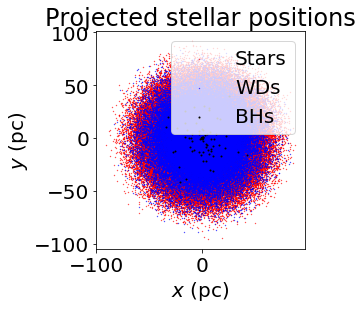

Text(0.5,1,'Projected stellar velocities')

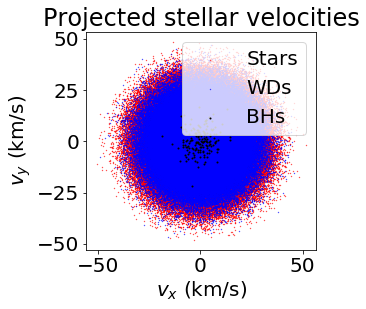

In [15]:
# Generate random solid angle positions, append additional quantities
snap.make_2d_projection(seed=8675309)

X = snap.data['x[PC]']
Y = snap.data['y[PC]']
VX = snap.data['vx[KM/S]']
VY = snap.data['vy[KM/S]']


binflag = (snap.data['binflag'] == 1) # binarity flag
startype_star = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
startype_wd = np.array([10, 11, 12])
startype_bh = np.array([14])

starflag = np.in1d(snap.data['startype'], startype_star)
wdflag = np.in1d(snap.data['startype'], startype_wd)
bhflag = np.in1d(snap.data['startype'], startype_bh)

# Plot stellar positions
plt.scatter(X[starflag & ~binflag], Y[starflag & ~binflag], c='r', s=0.1, label='Stars')
plt.scatter(X[wdflag & ~binflag], Y[wdflag & ~binflag], c='b', s=0.1, label='WDs')
plt.scatter(X[bhflag & ~binflag], Y[bhflag & ~binflag], c='k', s=1, label='BHs')

plt.gca().set_aspect('equal')

plt.legend(loc='upper right')
plt.xlabel('$x$ (pc)')
plt.ylabel('$y$ (pc)')
plt.title('Projected stellar positions')

plt.show()

# Plot stellar positions
plt.scatter(VX[starflag & ~binflag], VY[starflag & ~binflag], c='r', s=0.1, label='Stars')
plt.scatter(VX[wdflag & ~binflag], VY[wdflag & ~binflag], c='b', s=0.1, label='WDs')
plt.scatter(VX[bhflag & ~binflag], VY[bhflag & ~binflag], c='k', s=1, label='BHs')

plt.gca().set_aspect('equal')

plt.legend(loc='upper right')
plt.xlabel('$v_x$ (km/s)')
plt.ylabel('$v_y$ (km/s)')
plt.title('Projected stellar velocities')

0.003246362815759282
mbin: 260 cum: 260
mbin_2d: 200 cum_2d: 200


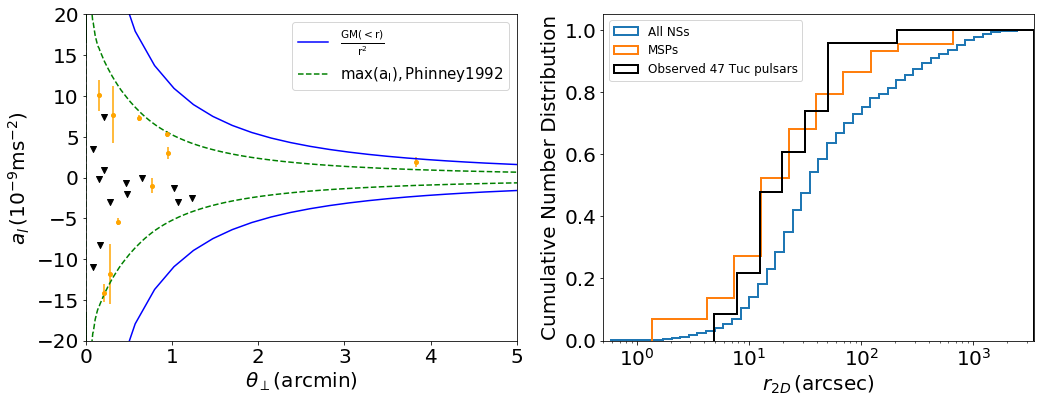

In [11]:
##Cluster acceleration from the model
snap = cmct.Snapshot(fname=path+'initial.snapshots.h5', snapshot_name='/797(t=0.53090065)', 
                     conv=path+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)

r_snap = np.array(snap.data['r']); m_snap = np.array(snap.data['m_MSUN'])
#print(r_snap)
max_r = r_snap[-1]; min_r = r_snap[0]
print(min_r)

bin_no = 201
def Acc_los_model(d47 = 4.52):
    l_conv = dyn.conv('l', path+'initial.conv.sh')

    ##From snapshot file
    #rbin = np.logspace(np.log10(min_r), np.log10(max_r), bin_no-50)  ##in code unit
    rbin = np.linspace(min_r, max_r, bin_no+60)  ##in code unit
    rbin_med = []
    for xx in range(len(rbin)-1):
        rbin_med.append((rbin[xx+1]+rbin[xx])/2.)
        
    
    mbin = []
    i_count = 0
    for ii in range(len(rbin)-1):
        mtot = 0
        for xx in range(len(r_snap)):
            if rbin[ii]<= r_snap[xx] < rbin[ii+1]:
                mtot += m_snap[xx]
            
        mbin.append(mtot)
    
    cum_mbin = np.cumsum(mbin)
    #print(mbin)
    print('mbin:', len(mbin), 'cum:', len(cum_mbin))

    acc_max = Gconst_sun*cum_mbin/(np.array(rbin_med)*l_conv)**2*(1e6/(PC*0.01))#*math.sqrt(1./3.)
    acc_min = -Gconst_sun*cum_mbin/(np.array(rbin_med)*l_conv)**2*(1e6/(PC*0.01))#*(math.sqrt(1./3.))
    #theta_bin = rbin[1:]*l_conv*math.sqrt(2./3.)/(d47*1000.)*180/np.pi*60
    theta_bin = np.array(rbin_med)*l_conv/(d47*1000.)*180/np.pi*60
    
    
    
    ##From 2D projection
    rbin_2d = np.logspace(np.log10(0.001), np.log10(96.7177), bin_no)  ##in parsec
    #rbin_2d = np.linspace(0.0005, 96.7177, 201)
    #print(rbin_2d)
    rbin_2d_med = []
    for xx in range(len(rbin_2d)-1):
        rbin_2d_med.append((rbin_2d[xx+1]+rbin_2d[xx])/2.)
        
    #print(len(rbin_2d_med))
        
    
    r_2dsnap = []; m_2dsnap = []
    with gzip.open(path+'initial.snap797.2Dproj.dat.gz', 'r') as f2d:
        next(f2d); next(f2d)
        for line in f2d:
            data = line.split()
            
            r_2dsnap.append(float(data[0]))
            m_2dsnap.append(float(data[9]))          
            
    np.savetxt(path+'r_m_797_2Dproj.txt', np.c_[r_2dsnap, m_2dsnap], fmt = '%f %f', 
               header = '1.r[PC] 2.m[MSUN]', comments = '#')
    
    data_2dsnap = np.genfromtxt(path+'r_m_797_2Dproj.txt')
    r_2dsnap = data_2dsnap[:,0]; m_2dsnap = data_2dsnap[:,1]
            
    mbin_2d = []
    for ii in range(len(rbin_2d)-1):
        mtot = 0
        for xx in range(len(r_2dsnap)):
            if rbin_2d[ii]<= r_2dsnap[xx] < rbin_2d[ii+1]:
                mtot += m_2dsnap[xx]
            
        mbin_2d.append(mtot)
    
    
    cum_mbin_2d = np.cumsum(mbin_2d)
    #print(mbin)
    print('mbin_2d:', len(mbin_2d), 'cum_2d:', len(cum_mbin_2d))

    acc_max_2d = 1.1*Gconst_sun*cum_mbin_2d/(np.pi*np.array(rbin_2d_med)**2)*(1e6/(PC*0.01))
    acc_min_2d = -1.1*Gconst_sun*cum_mbin_2d/(np.pi*np.array(rbin_2d_med)**2)*(1e6/(PC*0.01))
    theta_bin_2d = np.array(rbin_2d_med)/(d47*1000.)*180/np.pi*60

    return theta_bin, acc_max, acc_min, theta_bin_2d, acc_max_2d, acc_min_2d
    
    
#Acc_los_model()




##Line-of-acceleration profile and cumulative projected radial distribution of observed pulsars & model NSs 
#####################################
##Line-of-sight acceleration
##Observation
data47= np.genfromtxt('/projects/b1095/syr904/projects/massive_clusters/47Tuc_psr_acceleration.dat', dtype = str)
pspin = data47[:,6].astype(np.float); pobs_dot = (data47[:,7].astype(np.float))*1e-21
pm_alpha = data47[:,8].astype(np.float); pm_delta = data47[:,9].astype(np.float)
dec = data47[:,10].astype(np.float)

theta_los = data47[:,2].astype(np.float)
algc_max = data47[:,11].astype(np.float)
algc = data47[:,12].astype(np.float); algc_uncert = data47[:,13].astype(np.float)


d47 = 4.52  ##kpc
##The difference between the accelerations of the Solar system and 47 Tuc.
a47 = -1.172*1e-10 ## m/s^−2
#pm_alpha = 4; pm_delta = 1
#delta = -(72.+5./60.+1.48/3600.)
#pobs_dot = -4.56*1e-21; pspin = 4.554447383906 ##ms


##Calculate 47Tuc-X acceleration
#pbx = 10.921183545  #day
#pb_dotx = 6*1e-12 
#pm_alphax = 5.8; pm_deltax = -3.3; deltax = -72.021512
#pobs_dotx = 18.3609*1e-21; pspinx = 4.77152291069355 ##ms
#pm2x = pm_deltax**2+(pm_alphax*np.cos(deltax))**2
#vt2x = (pm2x/1e6)*(4.74*d47*1000.)**2*1e6 ##(m/s)^2
#Ax = pb_dotx/(pbx*24.*3600.)*(clight/100.)
#Bx = vt2x/(d47*1000.*PC/100.)
#algcx = Ax-Bx-a47
#print(algcx)

#print(np.cos(np.pi))
##Calculate algc upper limits
pm2 = pm_delta**2+(pm_alpha*np.cos(dec*np.pi/180))**2
vt2 = (pm2/1e6)*(4.74*d47*1000.)**2*1e6 ##(m/s)^2

A = pobs_dot/(pspin/1000.)*(clight/100.)
B = vt2/(d47*1000.*PC/100.)

#print(B)

al_max = A-B-a47
#print(al_max)
#print(np.array(B[algc!=-100]*1e9)/np.abs(algc[algc!=-100]))
#print(np.array(B[algc==-100]*1e9)/np.abs(algc[algc==-100]))

##Model
the_bin, accmax, accmin, the_bin_2d, accmax_2d, accmin_2d = Acc_los_model(d47 = 4.52)

matplotlib.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(ncols = 2, figsize = (17, 6))
axs[0].scatter(theta_los[algc==-100], algc_max[algc==-100], marker = 'v', color = 'k')
axs[0].errorbar(theta_los[algc!=-100], algc[algc!=-100], yerr = algc_uncert[algc!=-100], fmt = 'o', markersize = 4, 
                color = 'orange')
axs[0].plot(the_bin, accmax*1e9, color = 'b', label = r'$\rm{\frac{GM(<r)}{r^2}}$')
axs[0].plot(the_bin, accmin*1e9, color = 'b')
axs[0].plot(the_bin_2d, accmax_2d*1e9, color = 'g', ls = '--', label = r'$\rm{max(a_l), Phinney 1992}$')
axs[0].plot(the_bin_2d, accmin_2d*1e9, color = 'g', ls = '--')
axs[0].set_xlim(xmin = 0, xmax = 5)
axs[0].set_ylim(ymin = -20, ymax = 20)
    
axs[0].set_xlabel(r'$\theta_{\perp} (\rm{arcmin})$')
axs[0].set_ylabel(r'$a_l\,(\rm{10^{-9}ms^{-2}})$')
axs[0].legend(loc = 'best', fontsize = 15)


#######################################
##Cumulative radial distribution
datamsp = np.genfromtxt(path+'MSP797.dat')
id_msp = datamsp[:,10]; sn_msp = datamsp[:,16]; tc_msp = datamsp[:,17]


rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []
with gzip.open(path+'initial.snap797.2Dproj.dat.gz', 'r') as f2d:
        next(f2d); next(f2d)
        for line in f2d:
            data2d = line.split()
            if int(data2d[2]) == 1:
                if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                    rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                    if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                        rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                        
                
            else:
                if int(data2d[3]) == 13: 
                    rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                    if float(data2d[12]) in id_msp:
                        rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                    
r_proj = np.array(rpc)/(d47*1000.)*180/np.pi*60*60
r_proj_msp = np.array(rpc_msp)/(d47*1000.)*180/np.pi*60*60

axs[1].hist(r_proj, bins = np.logspace(np.log10(min(r_proj)), np.log10(3500), 50), 
            cumulative = True, density = True, histtype = 'step', lw = 2., label = 'All NSs')
axs[1].hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(3500), 15), 
            cumulative = True, density = True, histtype = 'step', lw = 2., label = 'MSPs')
axs[1].hist(theta_los*60, bins = np.logspace(np.log10(min(theta_los*60)), np.log10(3500), 15), 
            cumulative = True, density = True, histtype = 'step', lw = 2., color = 'k', 
            label = 'Observed 47 Tuc pulsars')
axs[1].set_xscale('log')
axs[1].set_xlim(xmin = 0.5, xmax = 3500.)
axs[1].set_xlabel(r'$r_{2D}\,(\rm{arcsec})$')
axs[1].set_ylabel('Cumulative Number Distribution')
axs[1].legend(loc = 'upper left', fontsize = 12)

#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/psr_acc_distr.pdf', dpi=300)


#plt.figure()
#plt.hist(m_tot, bins = np.logspace(np.log10(min(m_tot)), np.log10(max(m_tot)), 50), histtype = 'step', 
#         label = 'All NSs')
#plt.hist(mtot_msp, bins = np.logspace(np.log10(min(mtot_msp)), np.log10(max(mtot_msp)), 50), histtype = 'step',
#         label = 'MSPs')
#plt.xscale('log')
#plt.yscale('log')
##plt.xlim(xmin = 0.1)
#plt.xlabel(r'$M\,(\rm{M_{\odot}})$')
#plt.legend(loc = 'best')



In [8]:
##Pulsars at snapshot with tidal capture turned on
##Observed pulsars
df_obs_psr = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/47tuc_pulsars.xlsx', 
                        skiprows = 1, 
                        names = ['Name', 'Offset', 'Periods', 'Pdot', 'DM', 'Pb', 'X', 'Ecc', 'Mcomp', 'Type'])
type_47tuc = np.array(df_obs_psr['Type'])
pb_47tuc= np.array(df_obs_psr['Pb']); mc_47tuc = np.array(df_obs_psr['Mcomp'])
type47 = type_47tuc[type_47tuc != 'i']
pb47 = pb_47tuc[type_47tuc != 'i']; mc47 = mc_47tuc[type_47tuc != 'i']
print(pb47, mc47)


snapno = 575
#################################################
##PULSARS
msp_elson = np.genfromtxt(path+'MSP'+str(snapno)+'.dat')
sma_elson = msp_elson[:,14]; sn_elson = msp_elson[:,16]; tcflag_elson = msp_elson[:,17]

psr_array = []
psr_bin = []
psr_notaic = []; psr_notgc = []
colns = [1,2,3,7,8,9,13,14,15]   ##r, B, P, rol1, mns, mc, kc, sma, ecc
for ii in range(len(colns)):
    num_col = int(colns[ii])
    psr_array.append(msp_elson[:,num_col])
    psr_bin.append(msp_elson[:,num_col][sma_elson != -100])
    psr_notaic.append(msp_elson[:,num_col][sn_elson != 4])
    psr_notgc.append([])
    for xx in range(len(msp_elson[:,num_col])):
        if tcflag_elson[xx] != 81 and tcflag_elson[xx] != 82 and tcflag_elson[xx] != 83:
            psr_notgc[ii].append(msp_elson[:,num_col][xx])
    psr_notgc[ii] = np.array(psr_notgc[ii])


pb_psr_bin = uc.au_to_period(np.array(psr_bin[-2]), np.array(psr_bin[4]), np.array(psr_bin[5]))
psr_bin.append(pb_psr_bin)
pb_psr = uc.au_to_period(np.array(psr_array[-2]), np.array(psr_array[4]), np.array(psr_array[5]))
psr_array.append(pb_psr)
pb_notaic = uc.au_to_period(np.array(psr_notaic[-2]), np.array(psr_notaic[4]), np.array(psr_notaic[5]))
psr_notaic.append(pb_notaic)
pb_notgc = uc.au_to_period(np.array(psr_notgc[-2]), np.array(psr_notgc[4]), np.array(psr_notgc[5]))
psr_notgc.append(pb_notgc)
            

##binaries
psr_notaic_bin = []
psr_sma = psr_notaic[-3] != -100
for ii in range(len(colns)+1):
    psr_notaic_bin.append(psr_notaic[ii][psr_sma])
    

psr_notgc_bin = []
psr_sma = psr_notgc[-3] != -100
for jj in range(len(colns)+1):
    psr_notgc_bin.append(psr_notgc[jj][psr_sma])
           
    
print('n_bin', len(psr_bin[-1]), 'n_all', len(psr_array[-1]))
print('n_bin_notaic', len(psr_notaic_bin[-1]), 'n_all_notaic', len(psr_notaic[-1]))
print('n_bin_notgc', len(psr_notgc_bin[-1]), 'n_all_notgc', len(psr_notgc[-1]))


#################################################
##TC NS-MS binaries and collision
nsms_elson = np.genfromtxt(path+'NSMS'+str(snapno)+'.dat')
tcflag_nsms = nsms_elson[:,12]; sn_nsms = nsms_elson[:,13]
sn_nsms_91 = sn_nsms[tcflag_nsms == 91]
sn_nsms_81 = sn_nsms[tcflag_nsms == 81]


nsms_array = []
nsms_tc = []; nsms_gc = []
colns_nsms = [2,3,6,7,5,9]   ##mns, mms, a_au, ecc, kc, rolc
for ii in range(len(colns_nsms)):
    num_nsms = colns_nsms[ii]
    nsms_array.append(nsms_elson[:,num_nsms])
    nsms_tc.append(nsms_elson[:,num_nsms][tcflag_nsms == 91])
    nsms_gc.append(nsms_elson[:,num_nsms][tcflag_nsms == 81])
    
pb_nsms = uc.au_to_period(np.array(nsms_array[2]), np.array(nsms_array[0]), np.array(nsms_array[1]))
nsms_array.append(pb_nsms)
nsms_tc.append(pb_nsms[tcflag_nsms == 91])
nsms_gc.append(pb_nsms[tcflag_nsms == 81])
print('n_tc_nsms', len(nsms_tc[-1]), 'n_gc_nsms', len(nsms_gc[-1]), 'n_nsms', len(nsms_array[-1]))


##TC NS-WD binaries and collision
nswd_elson = np.genfromtxt(path+'NSWD'+str(snapno)+'.dat')
tcflag_nswd = nswd_elson[:,12]; sn_nswd = nswd_elson[:,13]
sn_nswd_91 = sn_nswd[tcflag_nswd == 91]
sn_nswd_81 = sn_nswd[tcflag_nswd == 81]

nswd_array = []
nswd_tc = []; nswd_gc = []
colns_nswd = [2,3,6,7,5,9]   ##mns, mms, a_au, ecc, kc, rolc
for ii in range(len(colns_nswd)):
    num_nswd = colns_nswd[ii]
    nswd_array.append(nswd_elson[:,num_nswd])
    nswd_tc.append(nswd_elson[:,num_nswd][tcflag_nswd == 91])
    nswd_gc.append(nswd_elson[:,num_nswd][tcflag_nswd == 81])
    
pb_nswd = uc.au_to_period(np.array(nswd_array[2]), np.array(nswd_array[0]), np.array(nswd_array[1]))
nswd_array.append(pb_nswd)
nswd_tc.append(pb_nswd[tcflag_nswd == 91])
nswd_gc.append(pb_nswd[tcflag_nswd == 81])
print('n_tc_nswd', len(nswd_tc[-1]), 'n_gc_nswd', len(nswd_gc[-1]), 'n_nswd', len(nswd_array[-1]))


###########################
##Finally filtering out the disrupted ultra-compact binaries 
##with carbon WDs <~ 0.01 Msun from Deloye & Bildsten 2003
print('######################')
index_del_bin = []
for kk in range(len(psr_bin[-1])):
    if psr_bin[5][kk]<=0.05:
        print('pb', psr_bin[-1][kk]*24.*60., 'mc', psr_bin[5][kk], 'kc', psr_bin[6][kk], 
                'rolc', psr_bin[3][kk])
    
    if psr_bin[5][kk]<=0.01 and psr_bin[6][kk]>10:
        index_del_bin.append(kk)
        
psr_bin_filterucb = []
for xx in range(len(psr_bin)):
    new_array = np.delete(psr_bin[xx], index_del_bin)
    psr_bin_filterucb.append(new_array)



print('######################')
index_del_notaic = []
for kk in range(len(psr_notaic_bin[-1])):
    if psr_notaic_bin[5][kk]<=0.05:
        print('pb', psr_notaic_bin[-1][kk]*24.*60., 'mc', psr_notaic_bin[5][kk], 'kc', psr_notaic_bin[6][kk], 
                'rolc', psr_notaic_bin[3][kk])
    
    if psr_notaic_bin[5][kk]<=0.01 and psr_notaic_bin[6][kk]>10:
        index_del_notaic.append(kk)
        
psr_notaic_bin_filterucb = []
for xx in range(len(psr_notaic_bin)):
    new_array = np.delete(psr_notaic_bin[xx], index_del_notaic)
    psr_notaic_bin_filterucb.append(new_array)


print('######################')
index_del_notgc = []
for kk in range(len(psr_notgc_bin[-1])):
    if psr_notgc_bin[5][kk]<=0.05:
        print('pb', psr_notgc_bin[-1][kk]*24.*60., 'mc', psr_notgc_bin[5][kk], 'kc', psr_notgc_bin[6][kk], 
              'rolc', psr_notgc_bin[3][kk])
        
    if psr_notgc_bin[5][kk]<=0.01 and psr_notgc_bin[6][kk]>10:
        index_del_notgc.append(kk)
        
psr_notgc_bin_filterucb = []
for xx in range(len(psr_notgc_bin)):
    psr_notgc_bin_filterucb.append(np.delete(psr_notgc_bin[xx], index_del_notgc))
    
    
print('######################')
index_del_nswd_tc = []
for kk in range(len(nswd_tc[-1])):
    if nswd_tc[1][kk]<=0.05:
        print('pb', nswd_tc[-1][kk]*24.*60., 'mc', nswd_tc[1][kk], 'kc', nswd_tc[4][kk], 
              'rolc', nswd_tc[5][kk])
    
    if nswd_tc[1][kk]<=0.01 and nswd_tc[4][kk] > 10:
        index_del_nswd_tc.append(kk)
    
nswd_tc_filterucb = []
for xx in range(len(nswd_tc)):
    nswd_tc_filterucb.append(np.delete(nswd_tc[xx], index_del_nswd_tc))
     
sn_nswd_91_filterucb = np.delete(sn_nswd_91, index_del_nswd_tc)
        

print('######################')
index_del_nswd_gc = []
for kk in range(len(nswd_gc[-1])):
    if nswd_gc[1][kk]<=0.05:
        print('pb', nswd_gc[-1][kk]*24.*60., 'mc', nswd_gc[1][kk], 'kc', nswd_gc[4][kk], 
              'rolc', nswd_gc[5][kk])
        
    if nswd_gc[1][kk]<=0.01 and nswd_gc[4][kk] > 10:
        index_del_nswd_gc.append(kk)
    
nswd_gc_filterucb = []
for xx in range(len(nswd_gc)):
    nswd_gc_filterucb.append(np.delete(nswd_gc[xx], index_del_nswd_gc))

sn_nswd_81_filterucb = np.delete(sn_nswd_81, index_del_nswd_gc)

[2.25684 2.3577 0.22979 0.12066 0.13597 0.14725 1.18908 0.06623 1.20172
 1.12618 0.42911 0.21213 0.133 10.9212 0.52194 0.1793 0.3184] [0.18 0.19 0.015 0.024 0.025 0.02 0.21 0.03 0.1 0.2 0.14 0.35 0.14 0.42
 0.16 0.0089 0.235]
n_bin 43 n_all 44
n_bin_notaic 25 n_all_notaic 26
n_bin_notgc 16 n_all_notgc 17
n_tc_nsms 0 n_gc_nsms 2 n_nsms 8
n_tc_nswd 0 n_gc_nswd 27 n_nswd 50
######################
pb 110.5782030153638 mc 0.006492 kc 10.0 rolc 1.025645
pb 110.41690463811814 mc 0.006502 kc 10.0 rolc 1.025671
pb 102.1016216752292 mc 0.007029 kc 11.0 rolc 1.026584
pb 81.74716684625804 mc 0.008768 kc 10.0 rolc 1.029407
pb 106.9243300342637 mc 0.006714 kc 10.0 rolc 1.026044
pb 106.96739885649926 mc 0.006706 kc 11.0 rolc 1.026168
pb 110.23935594236835 mc 0.006499 kc 10.0 rolc 1.026234
pb 94.29006073655002 mc 0.007599 kc 10.0 rolc 1.027841
pb 109.57566678317552 mc 0.006552 kc 10.0 rolc 1.025759
pb 92.01299739922435 mc 0.007801 kc 11.0 rolc 1.027717
pb 75.37662208739745 mc 0.009516 kc 10.0 rolc 1.0

['b' 'b' 'bw' 'bw' 'bw' 'bw' 'b' 'bw' 'b' 'b' 'b' 'rb' 'rb' 'b' 'b' 'bw'
 'rb']


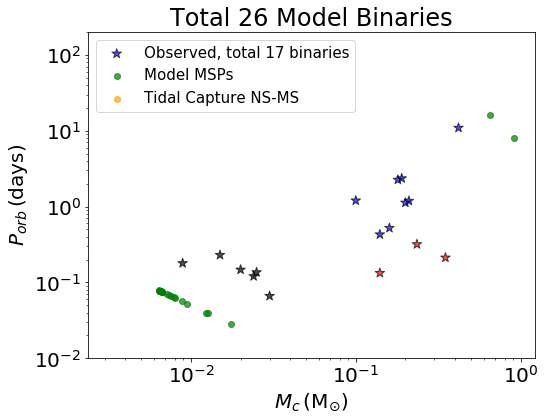

In [9]:
##Ploting Pb-Mc
##r, B, P, rol1, mns, mc, kc, sma, ecc, pb for psr_arrays
print(type47)
color47 = ['b', 'b', 'k', 'k', 'k', 'k', 'b', 'k', 'b', 'b', 'b', 'r', 'r', 'b', 'b', 'k', 'r']


matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(figsize = (8,6))

##All binary
axs.scatter(mc47, pb47, marker = '*', s = 100, color = 'k', facecolor = color47, alpha = 0.7, 
               label = 'Observed, total 17 binaries')
axs.scatter(psr_bin_filterucb[5], psr_bin_filterucb[-1], alpha = 0.7, 
               color = 'g', label = 'Model MSPs')
axs.scatter(nsms_tc[1][sn_nsms_91!=4], nsms_tc[-1][sn_nsms_91!=4], marker = 'o', 
               label = 'Tidal Capture NS-MS', alpha = 0.7, color = 'orange')

#print(len(psr_bin[5]), len(psr_bin_filterucb[5]),len(nsms_tc[1][sn_nsms_91!=4]),
#      len(nswd_tc_filterucb[1][sn_nswd_91_filterucb!=4]))

axs.set_title('Total 26 Model Binaries')

axs.set_yscale('log')
axs.set_xscale('log')
axs.set_ylabel(r'$P_{orb}\, (\rm{days})$')
axs.set_xlabel(r'$M_c\, (\rm{M_{\odot}})$')
axs.set_ylim(ymin = 0.01, ymax = 200)
axs.legend(loc = 'upper left', fontsize=15)

#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/psr_pb_mc.pdf', dpi=300)

['b' 'b' 'bw' 'bw' 'bw' 'bw' 'b' 'bw' 'b' 'b' 'b' 'rb' 'rb' 'b' 'b' 'bw'
 'rb']


NameError: name 'nswd_gc_filterucb' is not defined

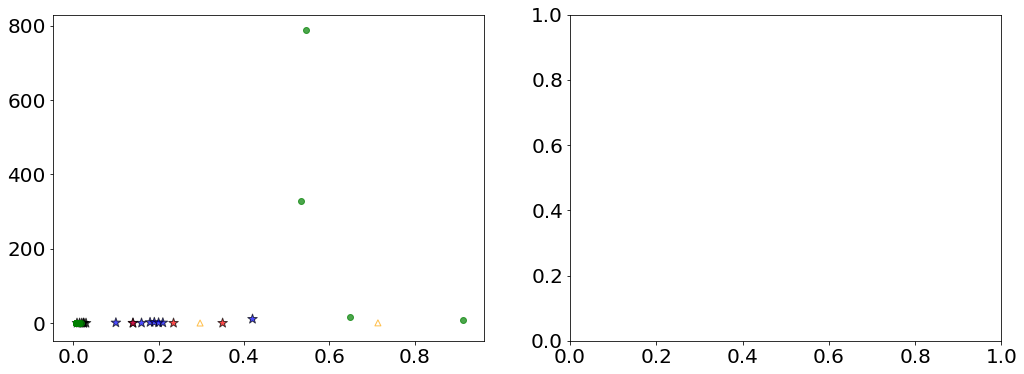

In [20]:
##Ploting Pb-Mc
##r, B, P, rol1, mns, mc, kc, sma, ecc, pb for psr_arrays
print(type47)
color47 = ['b', 'b', 'k', 'k', 'k', 'k', 'b', 'k', 'b', 'b', 'b', 'r', 'r', 'b', 'b', 'k', 'r']


matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(ncols = 2, figsize = (17,6))

##NOT AIC
axs[0].scatter(mc47, pb47, marker = '*', s = 100, color = 'k', facecolor = color47, alpha = 0.7, 
               label = 'Observed, total 17 binaries')
axs[0].scatter(psr_notaic_bin_filterucb[5], psr_notaic_bin_filterucb[-1], alpha = 0.7, 
               color = 'g', label = 'Model MSPs')
axs[0].scatter(nsms_tc[1][sn_nsms_91!=4], nsms_tc[-1][sn_nsms_91!=4], marker = 'o', 
               label = 'Tidal Capture NS-MS', alpha = 0.7, color = 'orange')
axs[0].scatter(nsms_gc[1][sn_nsms_81!=4], nsms_gc[-1][sn_nsms_81!=4], marker = '^', facecolor = 'none',
               label = 'Giant Collision NS-MS', alpha = 0.7, color = 'orange')
#axs[0].scatter(nswd_tc[1][sn_nswd_91!=4], nswd_tc[-1][sn_nswd_91!=4], marker = '^', 
#               label = 'Tidal Capture NS-WD', alpha = 0.7, color = 'orange')
axs[0].scatter(nswd_gc_filterucb[1][sn_nswd_81_filterucb!=4], nswd_gc_filterucb[-1][sn_nswd_81_filterucb!=4], 
               marker = '^', facecolor = 'none',
               label = 'Giant Collision NS-WD', alpha = 0.7, color = 'g')

#print(len(psr_notaic[5]), len(psr_notaic_bin_filterucb[5]),len(nsms_tc[1][sn_nsms_91!=4]),
      len(nswd_tc_filterucb[1][sn_nswd_91_filterucb!=4]), 
      len(nsms_gc[1][sn_nsms_81!=4]),len(nswd_gc_filterucb[1][sn_nswd_81_filterucb!=4]))

axs[0].set_title('Excluding AIC NSs\n Total 31 Model Binaries')

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel(r'$P_{orb}(days)$')
axs[0].set_xlabel(r'$M_{comp}(M_{\odot})$')
axs[0].set_ylim(ymin = 0.01)
axs[0].legend(loc = 'best', fontsize=15)



##NOT GC
axs[1].scatter(mc47, pb47, marker = '*', s = 100, facecolor = color47, alpha = 0.7, 
               color = 'k', label = 'Observed, total 17 binaries')
axs[1].scatter(psr_notgc_bin_filterucb[5], psr_notgc_bin_filterucb[-1], alpha = 0.7, 
               color = 'g', label = 'Model MSPs')
axs[1].scatter(nsms_tc[1], nsms_tc[-1], marker = 'o', 
               label = 'Model NS-MS', alpha = 0.7, color = 'orange')
#axs[1].scatter(nsms_gc[1][sn_nsms_81!=4], nsms_gc[-1][sn_nsms_81!=4], marker = '^', 
#               label = 'Model NS-MS', alpha = 0.7, color = 'orange')
#axs[1].scatter(nswd_tc[1], nswd_tc[-1], marker = '^', 
#               label = 'Model NS-WD', alpha = 0.7, color = 'orange')
#axs[1].scatter(nswd_gc[1][sn_nswd_81!=4], nswd_gc[-1][sn_nswd_81!=4], marker = '^', 
#               label = 'Model NS-WD', alpha = 0.7, color = 'r')

#print(len(psr_notgc[5]), len(psr_notgc_bin_filterucb[5]),len(nsms_tc[1]),len(nswd_tc_filterucb[1]))


axs[1].set_title('Excluding Giant Collision Binaries\n Total 15 Model Binaries')

axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_ylabel(r'$P_{orb}(days)$')
axs[1].set_xlabel(r'$M_{comp}(M_{\odot})$')
axs[1].set_ylim(ymin = 0.01)
axs[1].legend(loc = 'best', fontsize=15)

print(len(psr_bin[5]),len(nsms_tc[1]),len(nswd_tc[1]))

In [4]:
##CVs
wdms = np.genfromtxt(path+'WDMS726.dat')
rad1 = wdms[:,9]

n_cv = 0
for ii in range(len(rad1)):
    if rad1[ii]>=1.: n_cv+=1

print(n_cv)        

332


33451 31373


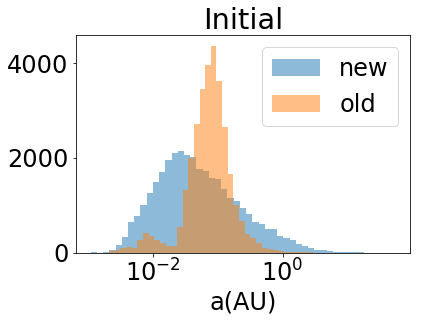

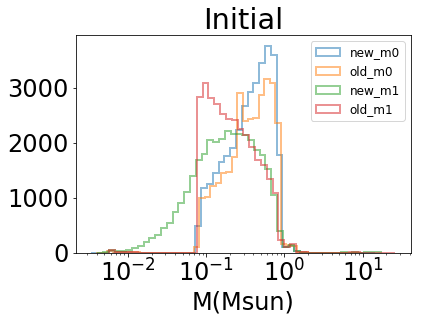

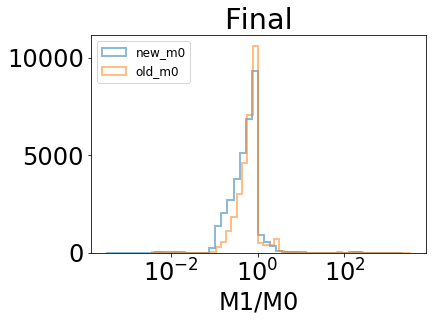

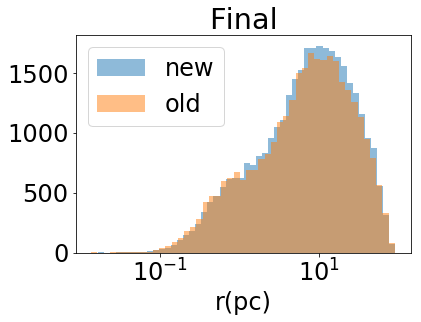

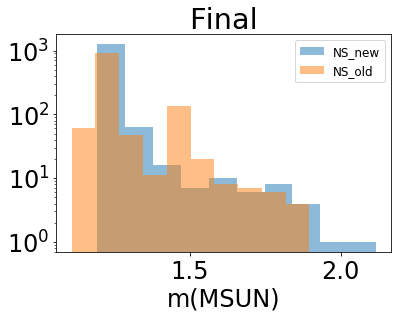

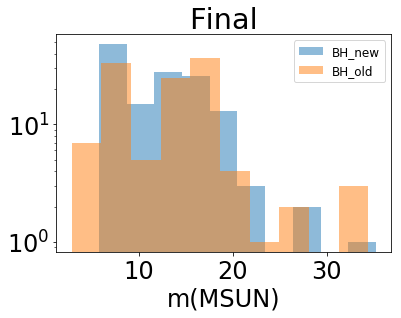

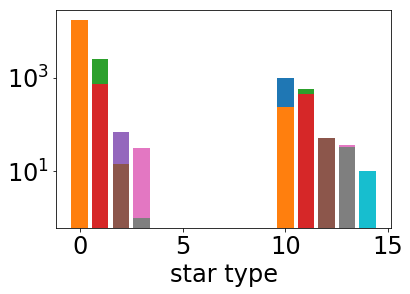

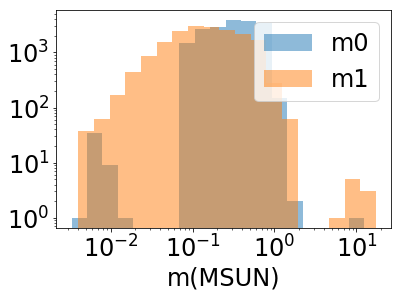

In [15]:
##Binary separation comparison between old 47 Tuc and new 47 Tuc best fits
#path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/8e5_rv1_rg8_fb0.05_Z0.001/'
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'

#with pd.HDFStore(path+'initial.snapshots.h5') as snap_hdf:
#    snap_keys = np.sort(snap_hdf.keys())
#
#t_conv = dyn.conv('t', path+'initial.conv.sh')
#
#def read_keys(thekey):
#    return re.findall(r'\d+\.\d+|\d+', thekey)
#
#snapno = []; snaptime = []
#for ii in range(len(snap_keys)):
#    theno = read_keys(snap_keys[ii])[0]; thetime = read_keys(snap_keys[ii])[1]
#    snapno.append(int(theno)); snaptime.append(thetime)
#    
#snapno_sort, snaptime_sort = (np.array(t) for t in zip(*sorted(zip(snapno, snaptime))))
##print(snapno_sort)
#np.savetxt(path+'snap_keys.txt',
#          np.c_[snapno_sort, snaptime_sort], fmt = '%s %s', header = '1.snap_no 2.snap_time', comments = '#')


snap = cmct.Snapshot(fname=path+'initial.snapshots.h5', snapshot_name='/784(t=0.62617053)',  #/784(t=0.62617053) /384(t=6.7827446)
                     conv=path+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)
binflag = snap.data['binflag']
sma = snap.data['a_AU']; m0 = snap.data['m0_MSUN']; m1 = snap.data['m1_MSUN']; m = snap.data['m_MSUN']
k0 = snap.data['bin_startype0']; k1 = snap.data['bin_startype1']; kstar = snap.data['startype']
r = snap.data['r']

sma_new = sma[binflag==1]; m0_new = m0[binflag==1]; m1_new = m1[binflag==1]
k0_new = k0[binflag==1]; k1_new = k1[binflag==1]
r_new = r[binflag==1]

m_allns_new = list(m[kstar==13])+list(m0[k0==13])+list(m1[k1==13])
m_allbh_new = list(m[kstar==14])+list(m0[k0==14])+list(m1[k1==14])

k0_tightsma = k0_new[sma_new<=0.05]; k1_tightsma = k1_new[sma_new<=0.05]
m0_tightsma = m0_new[sma_new<=0.05]; m1_tightsma = m1_new[sma_new<=0.05]

lconv_new = dyn.conv('l', path+'initial.conv.sh')
r_new = np.array(r_new)*lconv_new

#############################################################################
#snapold = '/projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.002/8e5/initial.snap0000.dat.gz'
#snapold = '/projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.002/8e5/initial.snap0384.dat.gz'
#snapold = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0000.dat.gz'
snapold = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0548.dat.gz'
sma_old = []; m0_old = []; m1_old = []; r_old = []
m_allns_old = []; m_allbh_old = []

with gzip.open(snapold, 'r') as fsnap:
    next(fsnap); next(fsnap)
    for line in fsnap:
        data = line.split()
        if int(data[7])== 1:
            sma_old.append(float(data[12]))
            m0_old.append(float(data[8]))
            m1_old.append(float(data[9]))
            r_old.append(float(data[2]))
            
            if int(data[17])==13: m_allns_old.append(float(data[8]))
            if int(data[18])==13: m_allns_old.append(float(data[9]))
                
            if int(data[17])==14: m_allbh_old.append(float(data[8]))
            if int(data[18])==14: m_allbh_old.append(float(data[9]))
            
        
        else:
            if int(data[14])==13: m_allns_old.append(float(data[1]))
            if int(data[14])==14: m_allbh_old.append(float(data[1]))
            
#print(m_allns_old)
lconv_old = dyn.conv('l', '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.conv.sh')          
r_old = np.array(r_old)*lconv_old
            
plt.figure()
plt.hist(sma_new, bins = np.logspace(np.log10(np.min(sma_new)), np.log10(np.max(sma_new)), 50), alpha = 0.5, label = 'new')
plt.hist(sma_old, bins = np.logspace(np.log10(np.min(sma_old)), np.log10(np.max(sma_old)), 50), alpha = 0.5, label = 'old')
#plt.hist(sma_new, alpha=0.5, label='new')
#plt.hist(sma_old, alpha=0.5, label='old')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('a(AU)')
plt.title('Initial')
plt.legend()


plt.figure()
plt.hist(m0_new, bins = np.logspace(np.log10(np.min(m0_new)), np.log10(np.max(m0_new)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'new_m0')
plt.hist(m0_old, bins = np.logspace(np.log10(np.min(m0_old)), np.log10(np.max(m0_old)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'old_m0')
plt.hist(m1_new, bins = np.logspace(np.log10(np.min(m1_new)), np.log10(np.max(m1_new)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'new_m1')
plt.hist(m1_old, bins = np.logspace(np.log10(np.min(m1_old)), np.log10(np.max(m1_old)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'old_m1')
#plt.hist(sma_new, alpha=0.5, label='new')
#plt.hist(sma_old, alpha=0.5, label='old')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('M(Msun)')
plt.title('Initial')
plt.legend(fontsize = 12)

mratio_new = np.array(m1_new)/np.array(m0_new)
mratio_old = np.array(m1_old)/np.array(m0_old)
print(len(mratio_new), len(mratio_old))
plt.figure()
plt.hist(mratio_new, bins = np.logspace(np.log10(np.min(mratio_new)), np.log10(np.max(mratio_new)), 50), 
         lw = 2, histtype = 'step', alpha = 0.5, label = 'new_m0')
plt.hist(mratio_old, bins = np.logspace(np.log10(np.min(mratio_old)), np.log10(np.max(mratio_old)), 50), 
         lw = 2, histtype = 'step', alpha = 0.5, label = 'old_m0')
#plt.hist(sma_new, alpha=0.5, label='new')
#plt.hist(sma_old, alpha=0.5, label='old')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('M1/M0')
plt.title('Final')
plt.legend(loc = 'upper left', fontsize = 12)



plt.figure()
plt.hist2d()
########################################################
plt.figure()
plt.hist(r_new, bins = np.logspace(np.log10(np.min(r_new)), np.log10(np.max(r_new)), 50),
         alpha = 0.5, label = 'new')
plt.hist(r_old, bins = np.logspace(np.log10(np.min(r_old)), np.log10(np.max(r_old)), 50),
         alpha = 0.5, label = 'old')
#plt.hist(sma_new, alpha=0.5, label='new')
#plt.hist(sma_old, alpha=0.5, label='old')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('r(pc)')
plt.title('Final')
plt.legend()


plt.figure()
#plt.hist(m_allns_new, bins = np.logspace(np.log10(np.min(m_allns_new)), np.log10(np.max(m_allns_new)), 20),
#         alpha = 0.5, label = 'NS_new')
#plt.hist(m_allns_old, bins = np.logspace(np.log10(np.min(m_allns_old)), np.log10(np.max(m_allns_old)), 20),
#         alpha = 0.5, label = 'NS_old')

#plt.hist(m_allbh_new, bins = np.logspace(np.log10(np.min(m_allbh_new)), np.log10(np.max(m_allbh_new)), 20),
#         alpha = 0.5, label = 'BH_new')
#plt.hist(m_allbh_old, bins = np.logspace(np.log10(np.min(m_allbh_old)), np.log10(np.max(m_allbh_old)), 20),
#         alpha = 0.5, label = 'BH_old')
plt.hist(m_allns_new, alpha=0.5, label='NS_new')
plt.hist(m_allns_old, alpha=0.5, label='NS_old')
plt.yscale('log')
plt.xlabel('m(MSUN)')
plt.title('Final')
plt.legend(fontsize=12)

plt.figure()
plt.hist(m_allbh_new, alpha=0.5, label='BH_new')
plt.hist(m_allbh_old, alpha=0.5, label='BH_old')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('m(MSUN)')
plt.title('Final')
plt.legend(fontsize=12)


plt.figure()
plt.bar(0, len(k0_tightsma[k0_tightsma==0]))
plt.bar(0, len(k1_tightsma[k1_tightsma==0]))
plt.bar(1, len(k0_tightsma[k0_tightsma==1]))
plt.bar(1, len(k1_tightsma[k1_tightsma==1]))
plt.bar(2, len(k0_tightsma[k0_tightsma==2]))
plt.bar(2, len(k1_tightsma[k1_tightsma==2]))
plt.bar(3, len(k0_tightsma[k0_tightsma==3]))
plt.bar(3, len(k1_tightsma[k1_tightsma==3]))
plt.bar(4, len(k0_tightsma[k0_tightsma==4]))
plt.bar(4, len(k1_tightsma[k1_tightsma==4]))

plt.bar(10, len(k0_tightsma[k0_tightsma==10]))
plt.bar(10, len(k1_tightsma[k1_tightsma==10]))
plt.bar(11, len(k0_tightsma[k0_tightsma==11]))
plt.bar(11, len(k1_tightsma[k1_tightsma==11]))
plt.bar(12, len(k0_tightsma[k0_tightsma==12]))
plt.bar(12, len(k1_tightsma[k1_tightsma==12]))
plt.bar(13, len(k0_tightsma[k0_tightsma==13]))
plt.bar(13, len(k1_tightsma[k1_tightsma==13]))
plt.bar(14, len(k0_tightsma[k0_tightsma==14]))
plt.bar(14, len(k1_tightsma[k1_tightsma==14]))

plt.xlabel('star type')
plt.yscale('log')

plt.figure()
plt.hist(m0_tightsma, bins = np.logspace(np.log10(np.min(m0_tightsma)), np.log10(np.max(m0_tightsma)), 20),
        label = 'm0', alpha=0.5)
plt.hist(m1_tightsma, bins = np.logspace(np.log10(np.min(m1_tightsma)), np.log10(np.max(m1_tightsma)), 20),
        label = 'm1', alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('m(MSUN)')
plt.legend()

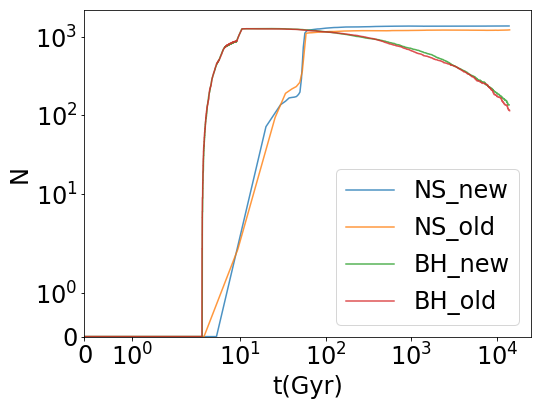

In [27]:
##Number of NSs and BHs comparison between old 47 Tuc and new 47 Tuc best fits
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'
path_old = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'

ns_new = np.genfromtxt(path_new+'initial.ns.dat')
bh_new = np.genfromtxt(path_new+'initial.bh.dat')

ns_old = np.genfromtxt(path_old+'initial.ns.dat')
bh_old = np.genfromtxt(path_old+'initial.bh.dat')

tconv_new = dyn.conv('t', path_new+'initial.conv.sh')
tconv_old = dyn.conv('t', path_old+'initial.conv.sh')


plt.figure(figsize = (8,6))
plt.plot(ns_new[:,0], ns_new[:,1], label='NS_new', alpha=0.8)
plt.plot(ns_old[:,0]*tconv_old, ns_old[:,1], label='NS_old', alpha=0.8)

plt.plot(bh_new[:,1]*tconv_new, bh_new[:,2], label='BH_new', alpha=0.8)
plt.plot(bh_old[:,1]*tconv_old, bh_old[:,2], label='BH_old', alpha=0.8)

plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel('t(Gyr)')
plt.ylabel('N')
plt.xlim(xmin = 0.)
plt.ylim(ymin = 0.)
plt.legend()

2937.0 4919.0
36518.0 46409.0
33451.0 31298.0


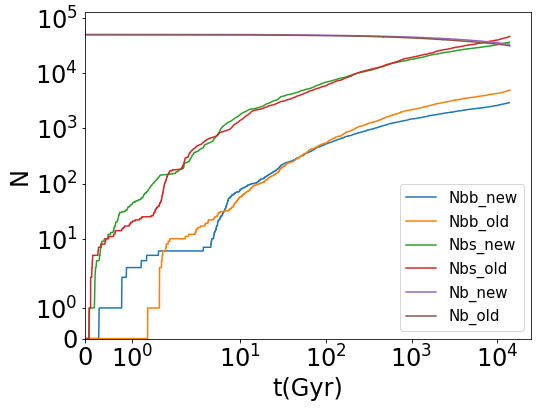

In [34]:
##Number of binary interactions comparison between old 47 Tuc and new 47 Tuc best fits
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'
path_old = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'

bin_new = np.genfromtxt(path_new+'initial.bin.dat')
bin_old = np.genfromtxt(path_old+'initial.bin.dat')

tconv_new = dyn.conv('t', path_new+'initial.conv.sh')
tconv_old = dyn.conv('t', path_old+'initial.conv.sh')


plt.figure(figsize = (8,6))
plt.plot(bin_new[:,0]*tconv_new, bin_new[:,8], label='Nbb_new')
plt.plot(bin_old[:,0]*tconv_old, bin_old[:,8], label='Nbb_old')

plt.plot(bin_new[:,0]*tconv_new, bin_new[:,9], label='Nbs_new')
plt.plot(bin_old[:,0]*tconv_old, bin_old[:,9], label='Nbs_old')

plt.plot(bin_new[:,0]*tconv_new, bin_new[:,1], label='Nb_new')
plt.plot(bin_old[:,0]*tconv_old, bin_old[:,1], label='Nb_old')

print(bin_new[:,8][-1], bin_old[:,8][-1])
print(bin_new[:,9][-1], bin_old[:,9][-1])
print(bin_new[:,1][-1], bin_old[:,1][-1])

plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel('t(Gyr)')
plt.ylabel('N')
plt.xlim(xmin = 0.)
plt.ylim(ymin = 0.)
plt.legend(loc = 'lower right', fontsize=15)

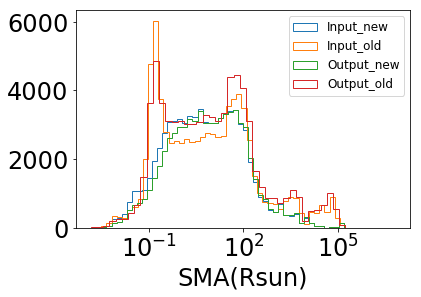

In [6]:
##Binary semi-major axis during interactions comparison between old 47 Tuc and new 47 Tuc best fits
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'
path_old = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'

binint_new = path_new+'initial.binint.log'
binint_old = path_old+'initial.binint.log'


sma_int_new = []; sma_int_old = []
sma_out_new = []; sma_out_old = []

fnew=open(binint_new,'r')
positions=scripts3.find_positions(fnew)
for ii in range(len(positions)-1):
    binint=scripts3.read_segment(fnew,positions[ii])
    bininput = binint['input']
    binoutput = binint['output']
    for xx in range(len(bininput)):
        if int(bininput[xx]['no'])==2:
            #print(bininput[xx]['a'])
            sma_int_new.append(float(bininput[xx]['a']))
    for yy in range(len(binoutput)):
        if int(binoutput[yy]['no'])==2:
            #print(binoutput[yy]['a'])
            sma_out_new.append(float(binoutput[yy]['a'][0]))
            
            
fold=open(binint_old,'r')
positions=scripts3.find_positions(fold)
for ii in range(len(positions)-1):
    binint=scripts3.read_segment(fold,positions[ii])
    bininput = binint['input']
    binoutput = binint['output']
    for xx in range(len(bininput)):
        if int(bininput[xx]['no'])==2:
            sma_int_old.append(float(bininput[xx]['a']))
    for yy in range(len(binoutput)):
        if int(binoutput[yy]['no'])==2:
            sma_out_old.append(float(binoutput[yy]['a'][0]))
            
            
plt.figure()
plt.hist(sma_int_new, bins = np.logspace(np.log10(np.min(sma_int_new)), np.log10(np.max(sma_int_new)), 50),
         histtype='step', label='Input_new')
plt.hist(sma_int_old, bins = np.logspace(np.log10(np.min(sma_int_old)), np.log10(np.max(sma_int_old)), 50),
         histtype='step', label='Input_old')

plt.hist(sma_out_new, bins = np.logspace(np.log10(np.min(sma_out_new)), np.log10(np.max(sma_out_new)), 50),
         histtype='step', label='Output_new')
plt.hist(sma_out_old, bins = np.logspace(np.log10(np.min(sma_out_old)), np.log10(np.max(sma_out_old)), 50),
         histtype='step', label='Output_old')

plt.xscale('log')
plt.xlabel('SMA(Rsun)')
plt.legend(fontsize=12)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional binary table                     NAXIS1  =                   88 / width of table in bytes                        NAXIS2  =                66001 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              TFIELDS =                   11 / number of fields in each row                   TTYPE1  = 'index   '           / label for field   1                            TFORM1  = '1K      '           / data format of field: 8-byte INTEGER           TUNIT1  = 'none    '           / physical unit of field                         TTYPE2  = 'id1     '           / label for field   2                            TFORM2  = '1K      '           / data fo

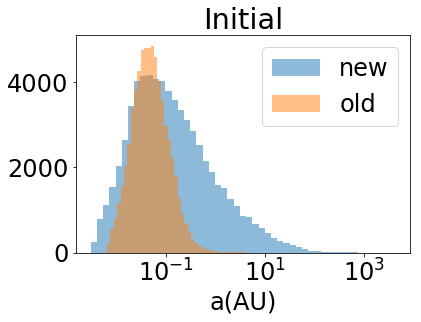

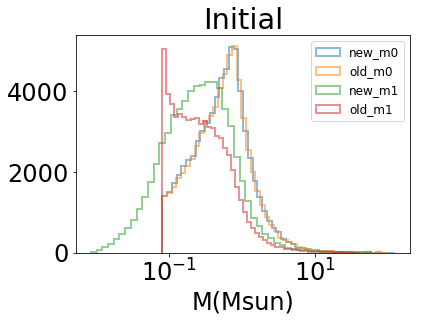

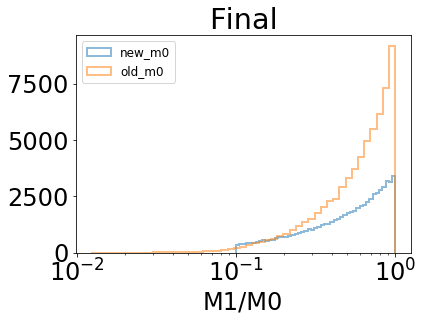

In [26]:
##Check the initial binary distributions
corr_path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon_correct_binary/'
m_conv = 2.48379e+06 #dyn.conv('m', corr_path+'initial.conv.sh')
l_conv = 4. #dyn.conv('l', corr_path+'initial.conv.sh')

from astropy.io import fits
infits = fits.open(corr_path+'input.fits')
#infits.info()
print(infits[2].header)
smafits = infits[2].data['a']
m1fits = infits[2].data['m2']
m0fits = infits[2].data['m1']
infits.close()

sma_old = np.delete(smafits, 0)
m0_old= np.delete(m0fits, 0)
m1_old = np.delete(m1fits, 0)

sma_old = sma_old*l_conv*PC_Rsun/AU_Rsun
m0_old = m0_old*m_conv
m1_old = m1_old*m_conv
###########################################
snap = cmct.Snapshot(fname='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snapshots.h5', 
                     snapshot_name='/0(t=0)',  #/784(t=0.62617053) /384(t=6.7827446)
                     conv='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)
binflag = snap.data['binflag']
sma = snap.data['a_AU']; m0 = snap.data['m0_MSUN']; m1 = snap.data['m1_MSUN']; m = snap.data['m_MSUN']
k0 = snap.data['bin_startype0']; k1 = snap.data['bin_startype1']; kstar = snap.data['startype']
r = snap.data['r']

sma_new = sma[binflag==1]; m0_new = m0[binflag==1]; m1_new = m1[binflag==1]
k0_new = k0[binflag==1]; k1_new = k1[binflag==1]
r_new = r[binflag==1]


#####################################
plt.figure()
plt.hist(sma_new, bins = np.logspace(np.log10(np.min(sma_new)), np.log10(np.max(sma_new)), 50), alpha = 0.5, label = 'new')
plt.hist(sma_old, bins = np.logspace(np.log10(np.min(sma_old)), np.log10(np.max(sma_old)), 50), alpha = 0.5, label = 'old')
#plt.hist(sma_new, alpha=0.5, label='new')
#plt.hist(sma_old, alpha=0.5, label='old')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('a(AU)')
plt.title('Initial')
plt.legend()


plt.figure()
plt.hist(m0_new, bins = np.logspace(np.log10(np.min(m0_new)), np.log10(np.max(m0_new)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'new_m0')
plt.hist(m0_old, bins = np.logspace(np.log10(np.min(m0_old)), np.log10(np.max(m0_old)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'old_m0')
plt.hist(m1_new, bins = np.logspace(np.log10(np.min(m1_new)), np.log10(np.max(m1_new)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'new_m1')
plt.hist(m1_old, bins = np.logspace(np.log10(np.min(m1_old)), np.log10(np.max(m1_old)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'old_m1')
#plt.hist(sma_new, alpha=0.5, label='new')
#plt.hist(sma_old, alpha=0.5, label='old')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('M(Msun)')
plt.title('Initial')
plt.legend(fontsize = 12)

mratio_new = np.array(m1_new)/np.array(m0_new)
mratio_old = np.array(m1_old)/np.array(m0_old)
print(len(mratio_new), len(mratio_old))
plt.figure()
plt.hist(mratio_new, bins = np.logspace(np.log10(np.min(mratio_new)), np.log10(np.max(mratio_new)), 50), 
         lw = 2, histtype = 'step', alpha = 0.5, label = 'new_m0')
plt.hist(mratio_old, bins = np.logspace(np.log10(np.min(mratio_old)), np.log10(np.max(mratio_old)), 50), 
         lw = 2, histtype = 'step', alpha = 0.5, label = 'old_m0')
#plt.hist(sma_new, alpha=0.5, label='new')
#plt.hist(sma_old, alpha=0.5, label='old')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('M1/M0')
plt.title('Final')
plt.legend(loc = 'upper left', fontsize = 12)

65533
65532 66000


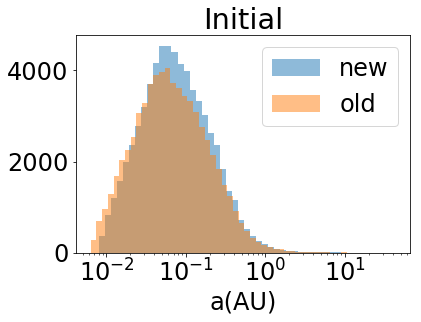

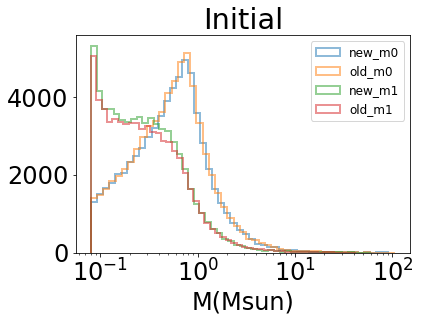

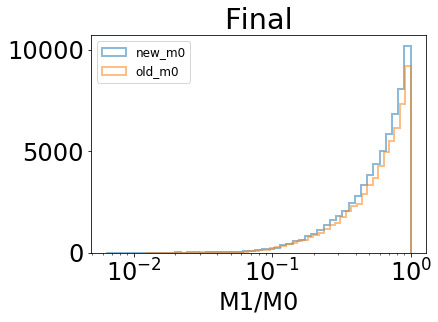

In [3]:
##Check the initial binary distributions
elson_init = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/old_IC/MOCHA47Tuc_elson_rv4_3e6_tcon_oldIC_rmax50/elson.hdf5'

m_conv = 2481309.2697858806
l_conv = 4.

with pd.HDFStore(elson_init) as init_hdf:
    allkeys = init_hdf.keys()

#print(allkeys)

bin_hd = pd.read_hdf(elson_init,
                     key = '/CLUS_BINARY_DATA')
#print(bin_hd.keys())

m0_hd =  bin_hd['m1']; m1_hd = bin_hd['m2']; sma_hd = bin_hd['a']
m0_new = m0_hd[1:]*m_conv
m1_new = m1_hd[1:]*m_conv
sma_new = sma_hd[1:]*l_conv*PC_Rsun/AU_Rsun
print(len(m0_hd))




#####################################################
corr_path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon_fixbin_ic/'
m_conv = 2.48379e+06 #dyn.conv('m', corr_path+'initial.conv.sh')
l_conv = 4. #dyn.conv('l', corr_path+'initial.conv.sh')

from astropy.io import fits
infits = fits.open(corr_path+'input.fits')
#infits.info()
#print(infits[2].header)
smafits = infits[2].data['a']
m1fits = infits[2].data['m2']
m0fits = infits[2].data['m1']
infits.close()

sma_old = np.delete(smafits, 0)
m0_old= np.delete(m0fits, 0)
m1_old = np.delete(m1fits, 0)

sma_old = sma_old*l_conv*PC_Rsun/AU_Rsun
m0_old = m0_old*m_conv
m1_old = m1_old*m_conv
###########################################
#snap = cmct.Snapshot(fname='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snapshots.h5', 
#                     snapshot_name='/0(t=0)',  #/784(t=0.62617053) /384(t=6.7827446)
#                     conv='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.conv.sh', 
#                     dist=4.52, # distance to cluster in kpc
#                     z=0.0038)
#binflag = snap.data['binflag']
#sma = snap.data['a_AU']; m0 = snap.data['m0_MSUN']; m1 = snap.data['m1_MSUN']; m = snap.data['m_MSUN']
#k0 = snap.data['bin_startype0']; k1 = snap.data['bin_startype1']; kstar = snap.data['startype']
#r = snap.data['r']
#
#sma_new = sma[binflag==1]; m0_new = m0[binflag==1]; m1_new = m1[binflag==1]
#k0_new = k0[binflag==1]; k1_new = k1[binflag==1]
#r_new = r[binflag==1]


#####################################
plt.figure()
plt.hist(sma_new, bins = np.logspace(np.log10(np.min(sma_new)), np.log10(np.max(sma_new)), 50), alpha = 0.5, label = 'new')
plt.hist(sma_old, bins = np.logspace(np.log10(np.min(sma_old)), np.log10(np.max(sma_old)), 50), alpha = 0.5, label = 'old')
#plt.hist(sma_new, alpha=0.5, label='new')
#plt.hist(sma_old, alpha=0.5, label='old')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('a(AU)')
plt.title('Initial')
plt.legend()


plt.figure()
plt.hist(m0_new, bins = np.logspace(np.log10(np.min(m0_new)), np.log10(np.max(m0_new)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'new_m0')
plt.hist(m0_old, bins = np.logspace(np.log10(np.min(m0_old)), np.log10(np.max(m0_old)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'old_m0')
plt.hist(m1_new, bins = np.logspace(np.log10(np.min(m1_new)), np.log10(np.max(m1_new)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'new_m1')
plt.hist(m1_old, bins = np.logspace(np.log10(np.min(m1_old)), np.log10(np.max(m1_old)), 50), lw = 2, histtype = 'step', alpha = 0.5, label = 'old_m1')
#plt.hist(sma_new, alpha=0.5, label='new')
#plt.hist(sma_old, alpha=0.5, label='old')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('M(Msun)')
plt.title('Initial')
plt.legend(fontsize = 12)

mratio_new = np.array(m1_new)/np.array(m0_new)
mratio_old = np.array(m1_old)/np.array(m0_old)
print(len(mratio_new), len(mratio_old))
plt.figure()
plt.hist(mratio_new, bins = np.logspace(np.log10(np.min(mratio_new)), np.log10(np.max(mratio_new)), 50), 
         lw = 2, histtype = 'step', alpha = 0.5, label = 'new_m0')
plt.hist(mratio_old, bins = np.logspace(np.log10(np.min(mratio_old)), np.log10(np.max(mratio_old)), 50), 
         lw = 2, histtype = 'step', alpha = 0.5, label = 'old_m0')
#plt.hist(sma_new, alpha=0.5, label='new')
#plt.hist(sma_old, alpha=0.5, label='old')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('M1/M0')
plt.title('Final')
plt.legend(loc = 'upper left', fontsize = 12)